Este documento es propiedad el **Equipo 7** y corresponde a la entrega *Momento de Retroalimentación: Reto Limpieza del Conjunto de Datos* del curso TC3006C. Nuestro equipo esta conformado por:

* Rodolfo Sandoval Schipper A01720253
* Marcelo Márquez A01720588
* Arturo Garza Campuzano A00828096

## Definición del problema

El 15 de abril de 1912 el Titanic RMS se hundió después de haber chocado con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos los que estaban a bordo, lo cual resultó en el fallecimiento de 1502 de los 2224 pasajeros y tripulantes. Si bien hubo algún elemento de suerte involucrado en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

El reto consiste en construir un modelo de predicción que responda a la siguiente pregunta: ¿qué tipo de personas tenían más probabilidades de sobrevivir? Para responderla se deben utilizar los datos de los pasajeros que están en los archivos train.csv y test.csv, disponibles en la plataforma Kaggle: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic).

El archivo train.csv contiene detalles de un subconjunto de 891 pasajeros, en el cual se revela cuáles de estos pasajeros sobrevivieron o no al accidente (ground truth). Por otro lado, el archivo test.csv contiene información similar pero no revela el resultado de supervivencia de cada pasajero. Este último archivo se utilizará para probar la efectividad del modelo de predicción. Utilizando los patrones encontrados en los datos de train.csv, se necesita predecir si los otros 418 pasajeros a bordo (test.csv) sobrevivieron.

La métrica de éxito para este reto corresponde al porcentaje de similitud que tienen los resultados de nuestro modelo comparado con los datos reales.

#### Librerias

In [104]:
from google.colab import drive

# Limpieza y analisis de datos
import pandas as pd
import numpy as np
import random as rnd
import math
from scipy.stats import skew, kurtosis

# Entrenamiento, validación y pruebas de Machine Learning
from sklearn.preprocessing import StandardScaler # Funcion para escalar datos
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz

%matplotlib inline

## **Evidencia 1: Limpieza y analisis del Conjunto de Datos**

La **limpieza de datos** es un proceso esencial para el análisis y procesamiento de datos que implica la detección y corrección de errores, inconsistencias y valores en conjuntos de datos. Durante esta etapa son requeridos los siguientes elementos:

* Limpia de datos con el uso de herramientas ETL
* Explicación y documentación de cada decisión tomada sobre cómo limpiar los atributos y valores. Se explica también cuáles son las variables que se creen que son más relevantes para el modelo y por qué.
* Aplicación de las transformaciones necesarias a los datos usando herramientas de ETL.
* Explicación y documentación de cada decisión que hayamos tomado sobre cómo transformar cada variable.

Esa limpieza se realizará sobre el conjunto de datos de un reto clásico: **predecir si una persona sobrevivió o no al desastre del Titanic**. Para conocer más sobre este reto se puede consultar el siguiente link: https://www.kaggle.com/competitions/titanic

Este proceso de limpieza comprendera de los siguientes **apartados**:
* Definición del problema
* Adquisición del conjunto de datos de entrenamiento y prueba para el modelo
* Imputar, preparar y limpiar datos
* Modelar, predecir y resolver el problema

In [105]:
# Limpieza y analisis de datos
import pandas as pd
import numpy as np
import random as rnd
import math
from scipy.stats import skew, kurtosis

# Entrenamiento, validación y pruebas de Machine Learning
from sklearn.preprocessing import StandardScaler # Funcion para escalar datos
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
import joblib

# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz

%matplotlib inline

### 1. Cargar datos (Extract)

In [106]:
#Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Datos/Evidencia01/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Datos/Evidencia01/test.csv')
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [107]:
# Filtrar pasajeros con "Fare" igual a 0.000000
pasajeros_con_fare_cero = train_df[train_df['Fare'] == 0.000000]

# Imprimir los pasajeros con "Fare" igual a 0.000000
print(len(pasajeros_con_fare_cero))
pasajeros_con_fare_cero

15


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


### 2. Exploración de la base de datos (EDA)

#### 2.1 Cálculo de mediads estadísticas

##### 2.1.1 Variables cuantitativas

Considerando la descripción de las variables proporcionada por el [diccionario de datos](https://www.kaggle.com/competitions/titanic/data) y los valores observados para cada variable se puede contemplar que las siguientes **variables** son **cuantitativas**: Age, SibSp, Parch y Fare.

Utilizando la función **describe()** se obtienen, por cada una de estas variables, los siguientes datos: cantidad de registros, media, desviación estándar, cuantiles, mínimo y máximo valor.

Estas vairables se guardan en un dataframe llamado **variables_cuantitativas** para facilitar su posterior análisis.

In [108]:
# Seleccionar las variables tipo number del dataframe original
variables_cuantitativas = train_df.select_dtypes(include=['number'])
variables_cuantitativas.drop(columns=['PassengerId', 'Survived', 'Pclass'], inplace=True)
variables_cuantitativas.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


**Observaciones:**
 - **Age** cuenta con valores nulos (19.87%).
 - Las métricas de **SibSp** y **Parch** no parecen ser tan diferentes, esto puede indicar que están relacionadas.
 - El mínimo para los valores de **Fare** es cero. Dentro del contexto del problema, esto significaría que algunos pasajeros accedieron de manera gratuita dentro del Titanic.

##### 2.1.2 Variables cualitativas

Tomando, otra vez, como referencia el [diccionario de datos](https://www.kaggle.com/competitions/titanic/data) y los valores observados para cada variable se puede contemplar que las siguientes **variables** son **categóricas**: Name, Sex, Ticket, Embarked, PassengerId, Survived y Pclass.  

Para cada una de estas variables se obtienen los siguientes datos: cantidad de registros, cantidad de valores únicos, primer valor y su respectiva frecuencia.

Estas variables se guardan en un dataframe llamado **variables_cualitativas** para facilitar su posterior análisis.

In [109]:
# Seleccionar las variables tipo object del dataframe original
variables_cualitativas = train_df.select_dtypes(include=['object'])
# Crea un data frame para visualizar la descripcion por variable
vcual_df = variables_cualitativas.describe(include=['O'])

# Variables que se quieren analizar
columns_to_analyze = ['PassengerId', 'Survived', 'Pclass']

# Obtiene los datos para las variables categoricas numericas
for column in columns_to_analyze:
    count = train_df[column].count()
    unique = train_df[column].nunique()
    top = train_df[column].value_counts().idxmax()
    frequency = train_df[column].value_counts().max()

    vcual_df[column] = [count, unique, top, frequency]

variables_cualitativas = variables_cualitativas.join(train_df[['PassengerId', 'Survived', 'Pclass']])

# Elimina la variable PassengerId
variables_cualitativas.drop(columns=['PassengerId'], inplace=True)

vcual_df

,Name,Sex,Ticket,Cabin,Embarked,PassengerId,Survived,Pclass
count,891,891,891,204,889,891,891,891
unique,891,2,681,147,3,891,2,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S,1,0,3
freq,1,577,7,4,644,1,549,491


Observaciones:

Todos los valores de Name y PassengerId son únicos.
Un procentaje considerable de los valores de Ticket (23.57%) y Cabin (27.94%) son únicos.
Hay valores nulos en Cabin (77.10%) y Embarked (0.22%).
Sex, Embarked, Survived y Pcalss cuentan con muy pocos valores únicos.

#### 2.2 Exploración de datos usando herramientas de visualización

##### 2.2.1 Vairbales cuantitativas

###### 2.2.1.1 Medidas de posición
Por cada variable cuantitativa se obtienen los cuartiles, se identifican los datos atípicos y se hace un diagrama de caja y bigotes.

In [110]:
# Calcula los cuartiles (25%, 50% y 75%)
cuartiles = variables_cuantitativas.quantile([0.25, 0.5, 0.75])

# Calcula el rango intercuartilico (IQR)
iqr = cuartiles.loc[0.75] - cuartiles.loc[0.25]

# Define los límites para detectar valores atípicos (outliers)
lower_bound = cuartiles.loc[0.25] - 1.5 * iqr
upper_bound = cuartiles.loc[0.75] + 1.5 * iqr

# Identifica los valores atípicos
outliers = ((variables_cuantitativas < lower_bound) | (variables_cuantitativas > upper_bound))

# Calcula la cantidad de valores atípicos por columna
outliers_count = outliers.sum()
outliers_count

Age       11
SibSp     46
Parch    213
Fare     116
dtype: int64

**Observaciones:**
- **Parch** (23.91%) y **Fare** (13.02%) cuentan con un alto porcentaje de datos atípicos considerando $Q1 - 1.5(IQR) \leq x \leq Q3 + 1.5(IQR)$ como los límites que los datos tiene que respetar.
- **SibSp** (5.16%) y **Age** (1.23%) cuentan con un porcentaje más bajo de datos atípicos considerando los mismos límites.

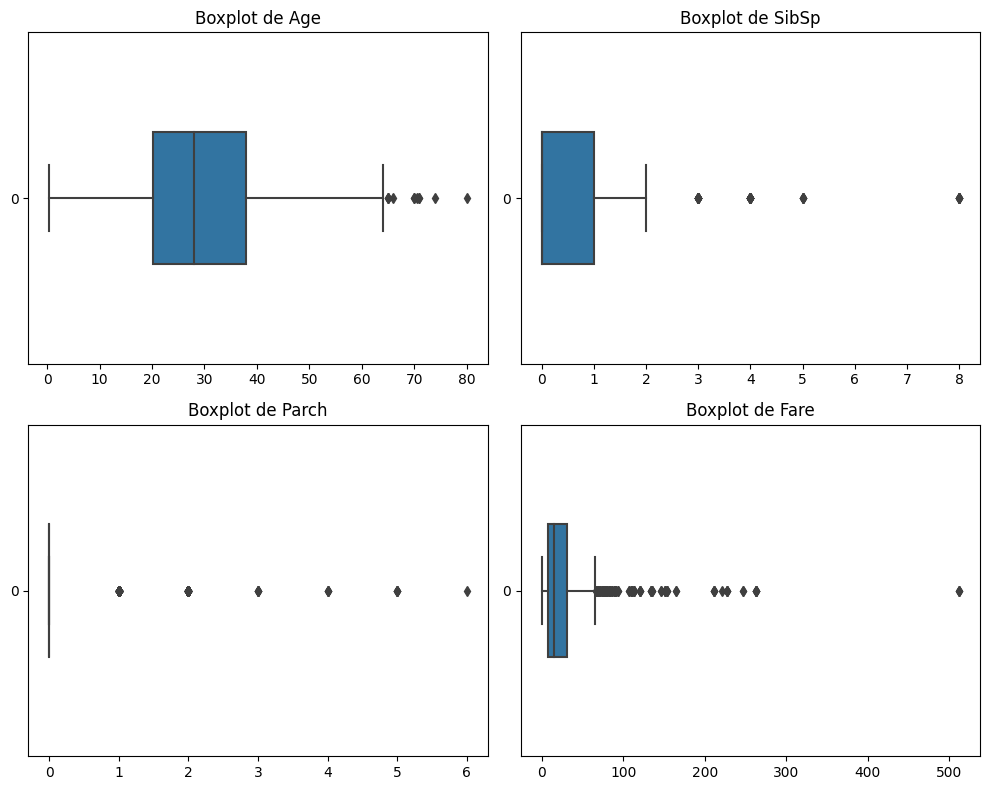

In [111]:
# Crear una figura y matriz de subtramas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Iterar sobre las subtramas y las columnas
for ax, column in zip(axes.flatten(), variables_cuantitativas):
    sns.boxplot(data=train_df[column], orient="h", width=0.4, ax=ax)
    ax.set_title(f"Boxplot de {column}")

# Ajustar diseño de subtramas y mostrar figura
plt.tight_layout()
plt.show()

**Observaciones:**
- Estos diagramas de caja y bigotes concuerdan con la cantidad de datos atípicos por variable.
- La mayor parte de los valores de **SibSp**, **Parch** y **Fare** son cercanos a cero.
- La mayoría de los pasajeros y tripulantes cuentan con una edad entre 20 y 40 años.

###### 2.2.1.2 Análisis de distribución de los datos

Con el objetivo de analizar la distribución de los datos de las variables cuentitativas se recurren a las siguientes herramientas herramientas: histogramas, sesgo y curtosis.

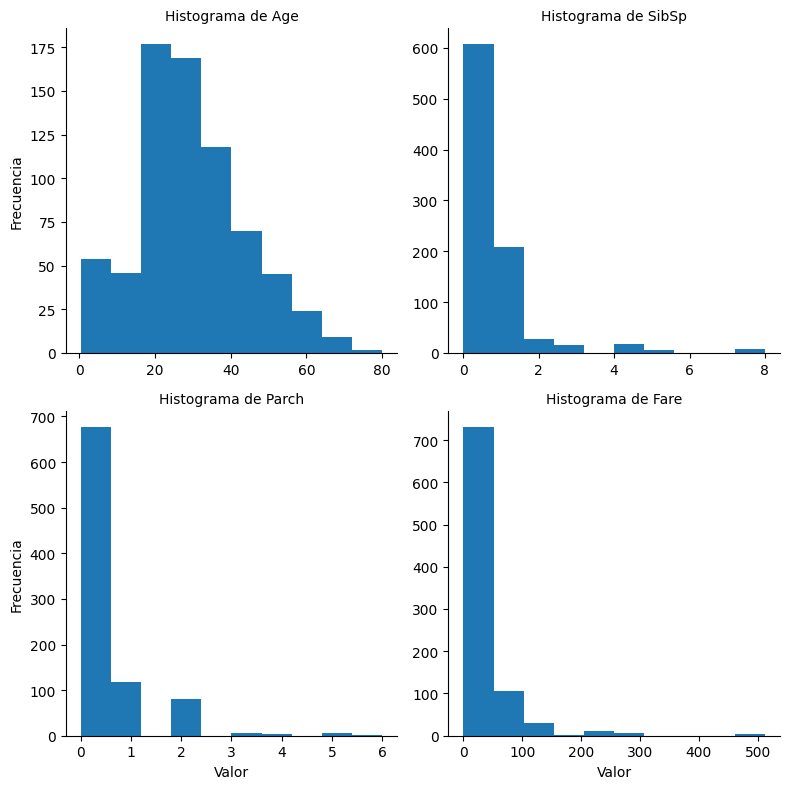

In [112]:
# Crear un FacetGrid para histogramas
g = sns.FacetGrid(variables_cuantitativas.melt(), col="variable", col_wrap=2, sharex=False, sharey=False, height=4)

# Mapear histogramas al FacetGrid
g.map(plt.hist, "value", bins=10)
g.set_titles(col_template="Histograma de {col_name}")
g.set_axis_labels("Valor", "Frecuencia")

# Ajustar layout y mostrar gráficas
plt.tight_layout()
plt.show()

**Observaciones**:
- **Age** es la única variable con posibilidad de que su distribución sea simétrica.
- La distribución de **SibSp**, **Parch** y **Fare** es asimétrica. Sus datos se encuentra agrupados a la izquierda.

In [113]:
# Calcular el sesgo y curtosis de cada variable
diccionario_resultados = {'Variable': [], 'Sesgo': [], 'Curtosis': []}

for columna in variables_cuantitativas.columns:
    # Filter out null values before calculating skewness and kurtosis (mencionar)
    not_null_values = variables_cuantitativas[columna].dropna()

    sesgo = skew(not_null_values, nan_policy='omit')
    curtosis = kurtosis(not_null_values, nan_policy='omit')

    diccionario_resultados['Variable'].append(columna)
    diccionario_resultados['Sesgo'].append(sesgo)
    diccionario_resultados['Curtosis'].append(curtosis)

# Crear un nuevo DataFrame con los resultados
estadisticas_df = pd.DataFrame(diccionario_resultados)

# Imprimir el nuevo DataFrame
estadisticas_df

,Variable,Sesgo,Curtosis
0,Age,0.388290,0.168637
1,SibSp,3.689128,17.773512
2,Parch,2.744487,9.716613
3,Fare,4.779253,33.204289


**Consideraciones**:
- Una distribución es simétrica cuando el coeficiente de sesgo esta entre -0.5 y 0.5.
- La forma de la distribución es mesocúrtica cuando el coeficiente de curtosis esta entre 2.5 y 3.5.

**Observaciones:**
- **Age** cuenta con la simetríca de la distribución y su forma es platicúrtica.
- **SibSp**, **Parch** y **Fare** cuentan con una distribución sesgada hacia la derecha y su forma es leptocúrtica.

###### 2.2.1.3 Análisis de colinealidad

Para analizar la colinealidad entre las variables cuantitativas y la supervivencia se utilizan las siguientes herramientas: histogramas de cada variable considerando el factor de supervivencia y diagramas de caja y bigote de cada variable por el factor de superviencia.


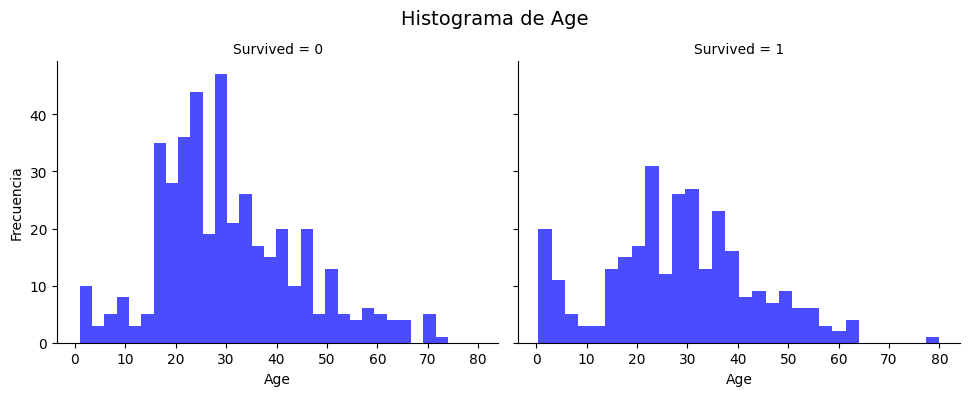

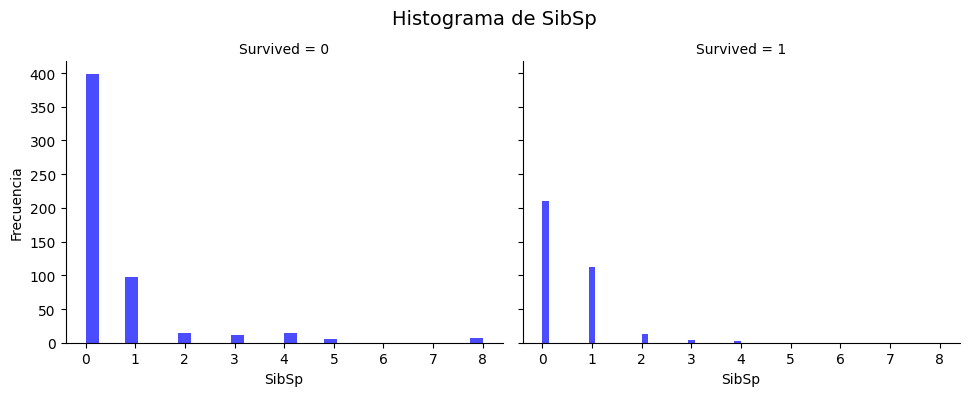

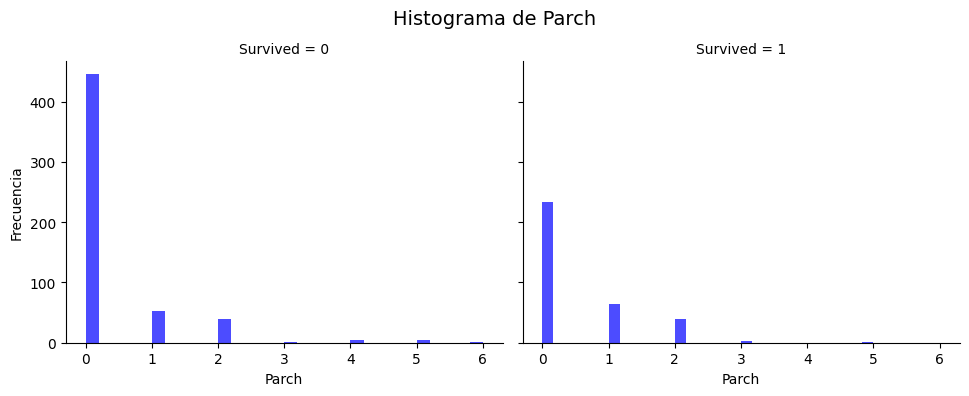

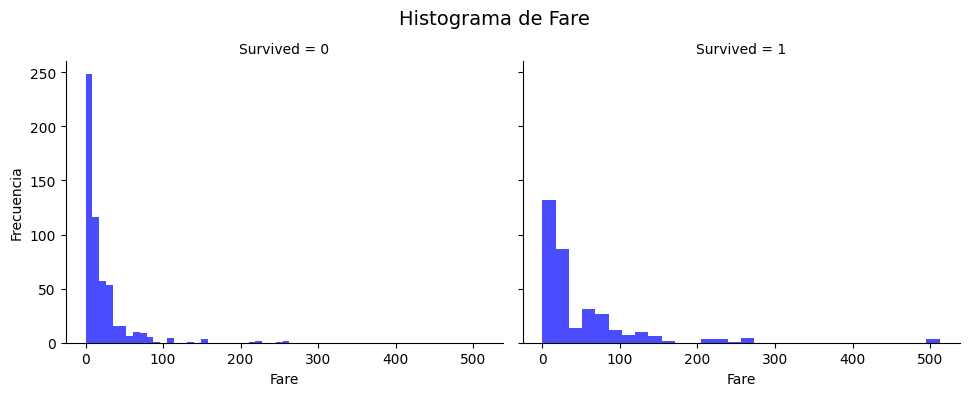

In [114]:
# Iterate through filtered columns
for variable in variables_cuantitativas:
    # Create a FacetGrid with a larger height and aspect ratio
    g = sns.FacetGrid(train_df, col='Survived', height=4, aspect=1.2)

    # Map a histogram for the current variable with adjusted bins
    g.map(plt.hist, variable, bins=30, color='blue', alpha=0.7)

    # Set a title for the current plot
    plt.subplots_adjust(top=0.85)  # Adjust the title position
    g.fig.suptitle(f'Histograma de {variable}', fontsize=14)

    # Set axis labels
    g.set_axis_labels(f'{variable}', 'Frecuencia')

# Show the plots
plt.show()

**Observación**: En todo par de distribuciones por variable cuantitativa parecer ser que la distribución mantienen su forma pero su propoción disminuye; las distribuciones de los que no sobrevivieron alcanzan valores más elevados que en las distribuciones pertenecientes a los supervivientes.

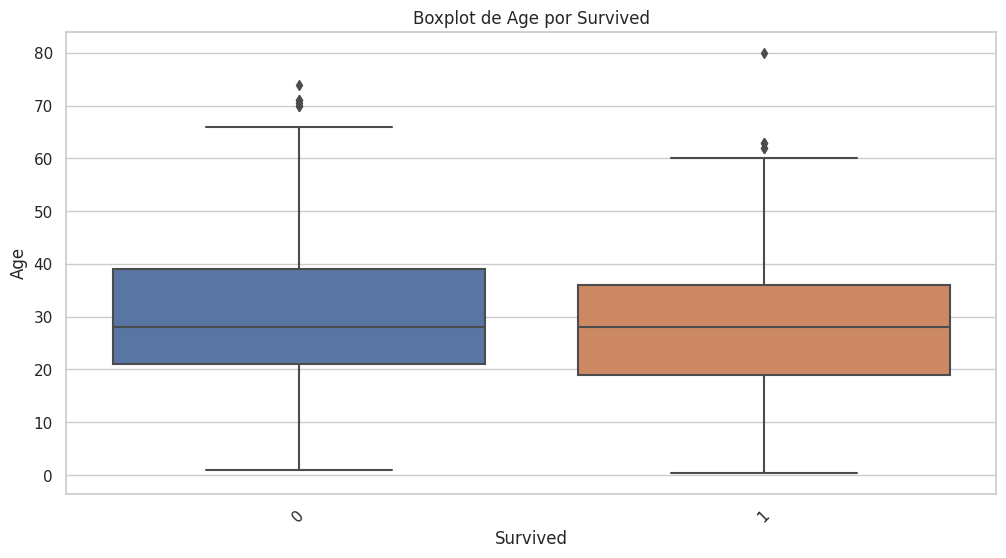

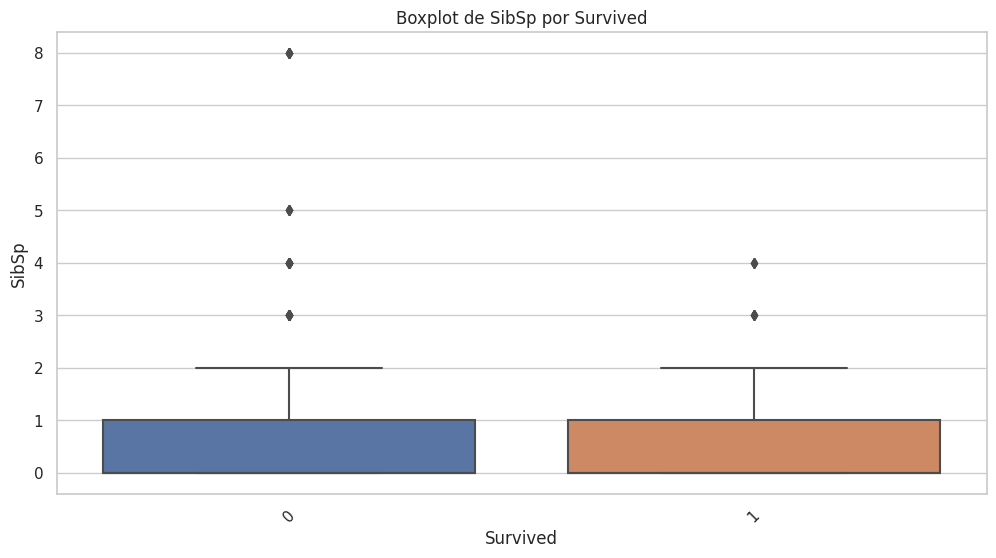

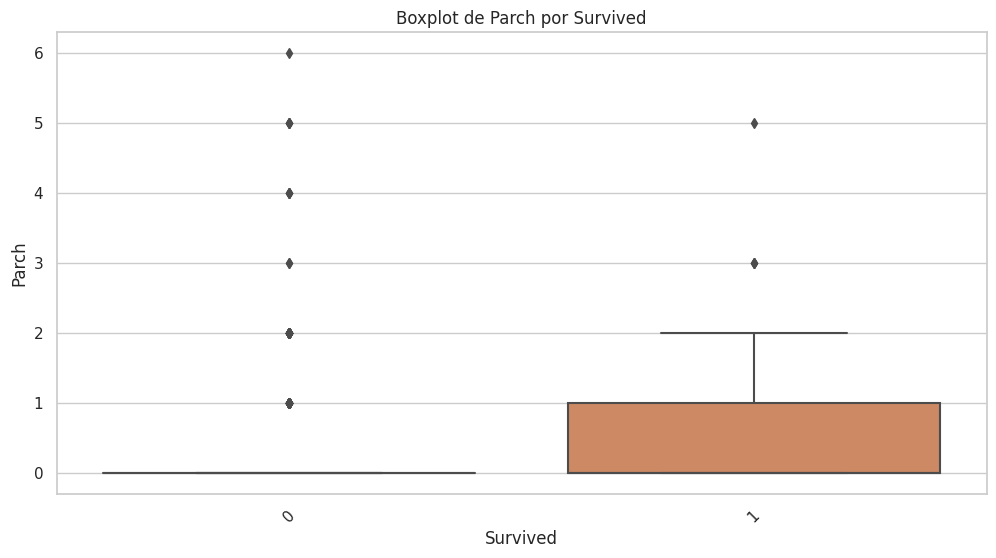

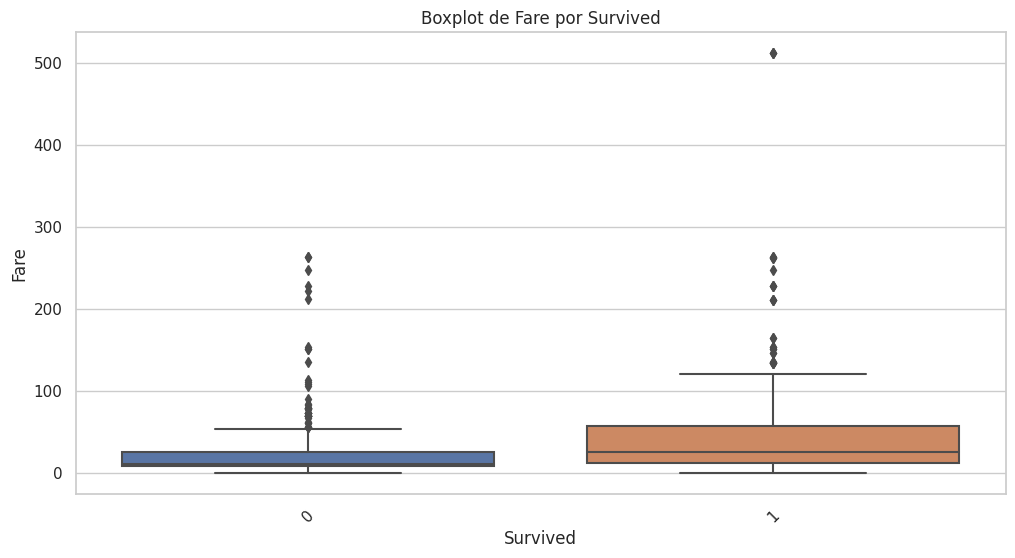

In [115]:
# Configura el estilo de Seaborn
sns.set(style="whitegrid")

# Itera a través de las columnas de variables_cualitativas
for categoria in variables_cuantitativas.columns:
    plt.figure(figsize=(12, 6))

    # Crea un boxplot para la variable categórica actual y la variable numérica (precio)
    sns.boxplot(x=train_df['Survived'], y=variables_cuantitativas[categoria])

    plt.title(f'Boxplot de {categoria} por Survived')
    plt.xlabel('Survived')
    plt.ylabel(categoria)
    plt.xticks(rotation=45)  # Para rotar las etiquetas del eje x

    # Guarda o muestra el gráfico, según sea necesario
    # plt.savefig(f'boxplot_{categoria}.png')
    plt.show()

**Observaciones**:
- Los diagramas de **Age** y **SibSp** paercen trasplaparse, lo cual indica que las variables no tienen una buena colinealidad con **Survived**.
- Los diagramas de **Parch** y **Fare** parece que no se traslapan, lo cual señala que las variables pueden tener una clase de colinealidad con **Survived**.

##### 2.2.2 Variables cualitativas

###### 2.2.2.1 Distribución de los datos

En este apartado se observa la distribución de los datos de las variables cualitativas con las siguientes herramientas: histogramas de frecuencias y gráficas de pastel.

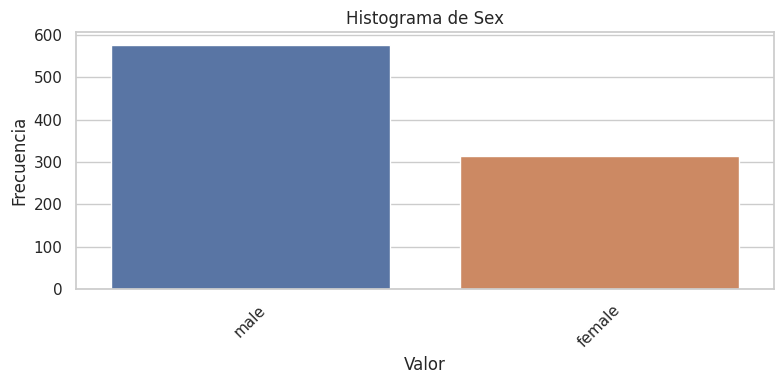

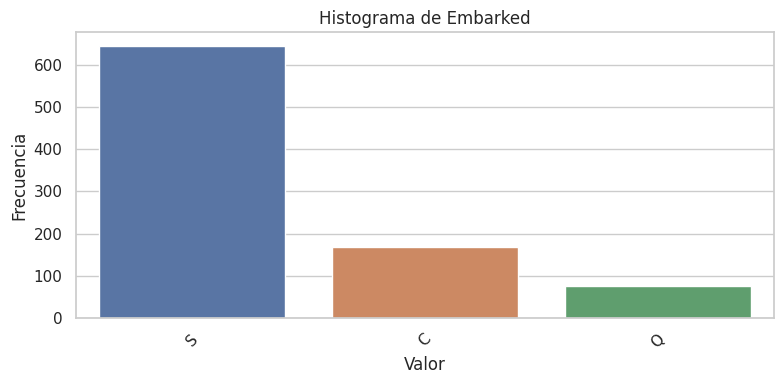

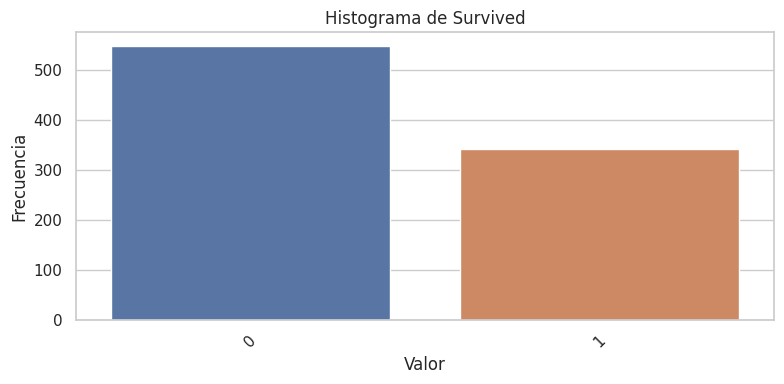

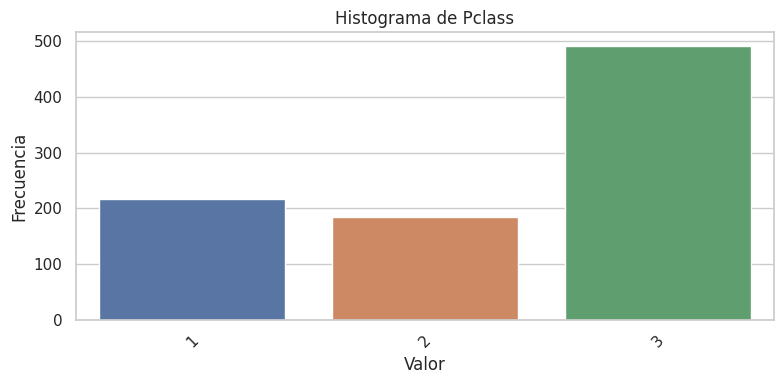

In [116]:
# Iterate through the qualitative columns
for variable in variables_cualitativas.columns:
    if variable not in ['Name', 'Ticket', 'Cabin']:
        plt.figure(figsize=(8, 4))  # Set the figure size as per your preferences

        # Create a bar plot using Seaborn
        sns.countplot(data=variables_cualitativas, x=variable)

        # Add a title for each plot
        plt.title(f'Histograma de {variable}')

        # Axis labels
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')

        # Rotate x-axis labels if needed
        plt.xticks(rotation=45)

        # Adjust layout and display plots
        plt.tight_layout()
        plt.show()

**Observaciones:**
- Hay el doble de hombres que de mujeres.
- La mayoría de los pasajeros embarcaron en Southampton.
- Sólo sobrevivieron un poco más de la mita de los pasajeros.
- La mitad de los pasajeros pertenecen a la clase tres.

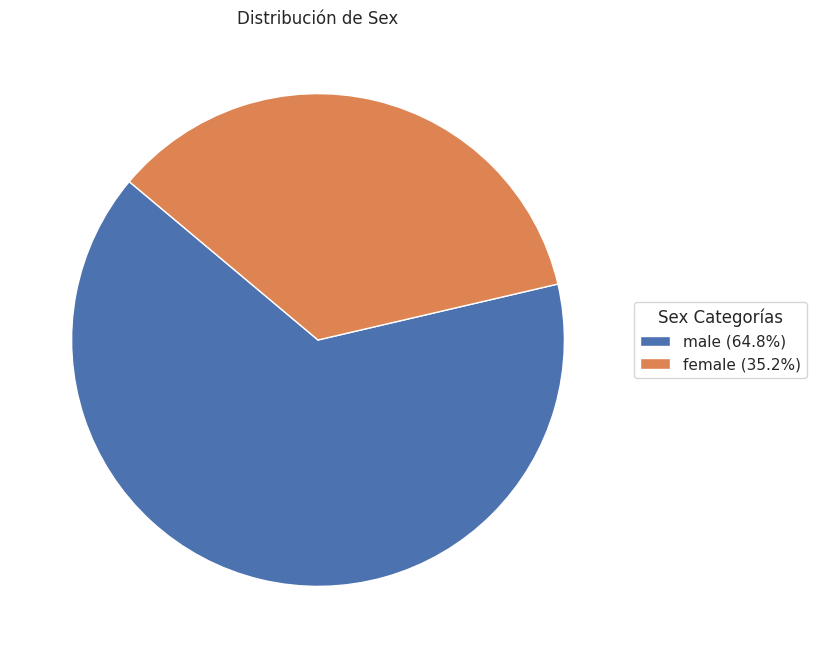

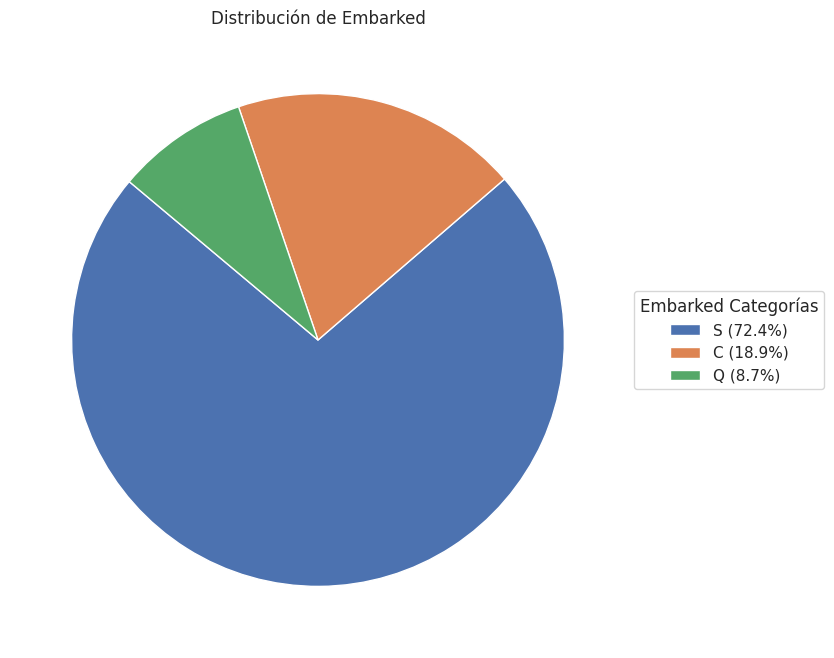

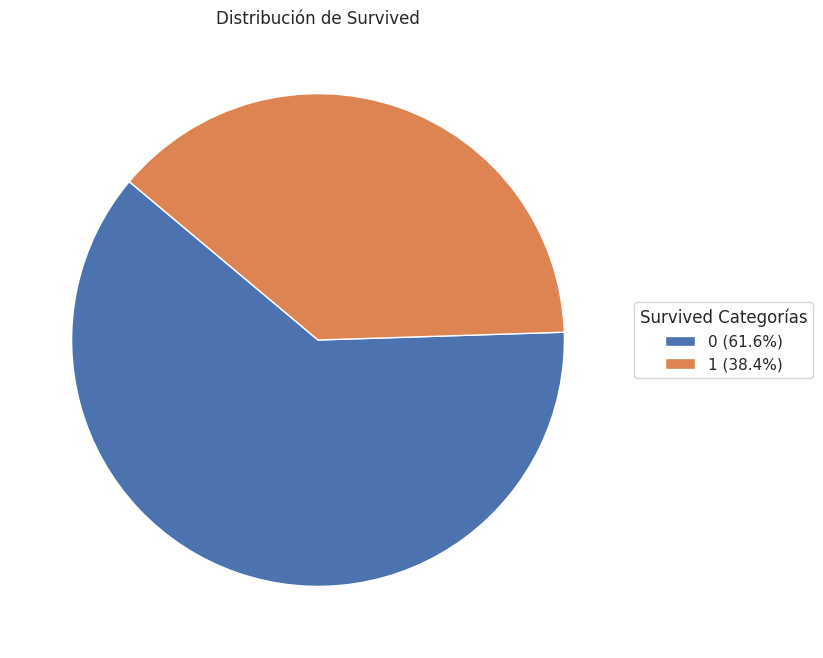

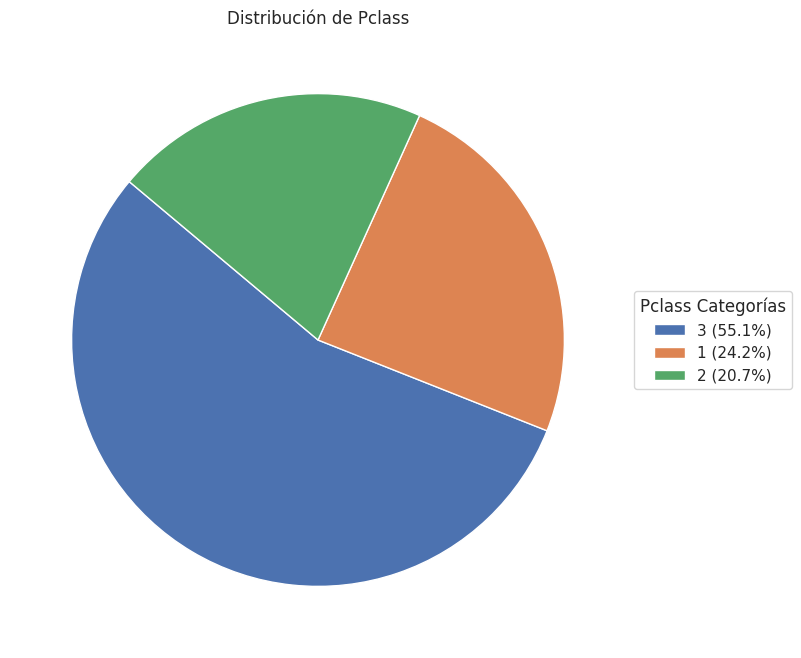

In [117]:
# Itera a través de las columnas cualitativas
for variable in variables_cualitativas.columns:
  if variable not in ['Name', 'Ticket', 'Cabin']:
    plt.figure(figsize=(8, 8))

    # Calcula la frecuencia de cada categoría
    data = variables_cualitativas[variable].value_counts()

    # Crea el diagrama de pastel utilizando Seaborn
    sns.set(style="whitegrid")  # Configura el estilo de Seaborn
    pie_chart, _, autopcts = plt.pie(data, labels=None, autopct='', startangle=140, pctdistance=0.85)

    # Obtiene los nombres de las categorías directamente desde el índice del DataFrame
    category_names = data.index

    # Calcula los porcentajes manualmente y crea una lista de etiquetas para la leyenda
    total = sum(data)
    percentages = [(count / total) * 100 for count in data]
    legend_labels = [f'{category} ({percentage:.1f}%)' for category, percentage in zip(category_names, percentages)]

    # Agrega un título específico para cada gráfico
    plt.title(f'Distribución de {variable}')

    # Agrega una leyenda con los colores, etiquetas y porcentajes
    plt.legend(legend_labels, title=f'{variable} Categorías', loc='center left', bbox_to_anchor=(1, 0.5))

    # Muestra el gráfico con un título y sin etiqueta en el eje y
    plt.ylabel('')

    plt.show()

**Observación:** En estos diagramas se contempla la distribución de los valores de cada variable de manera más exacta. Las observaciones previamiente realizadas solo fueron estimaciones. Se proporcionan estos procentajes con la intención de hacer referencia a ellos más adelante.

###### 2.2.2.2 Análisis de colinealidad
Para analizar la colinealidad entre las variables cualitativas y la supervivencia se utilizan histogramas de frecuencia de cada variable por factor de superviviencia.

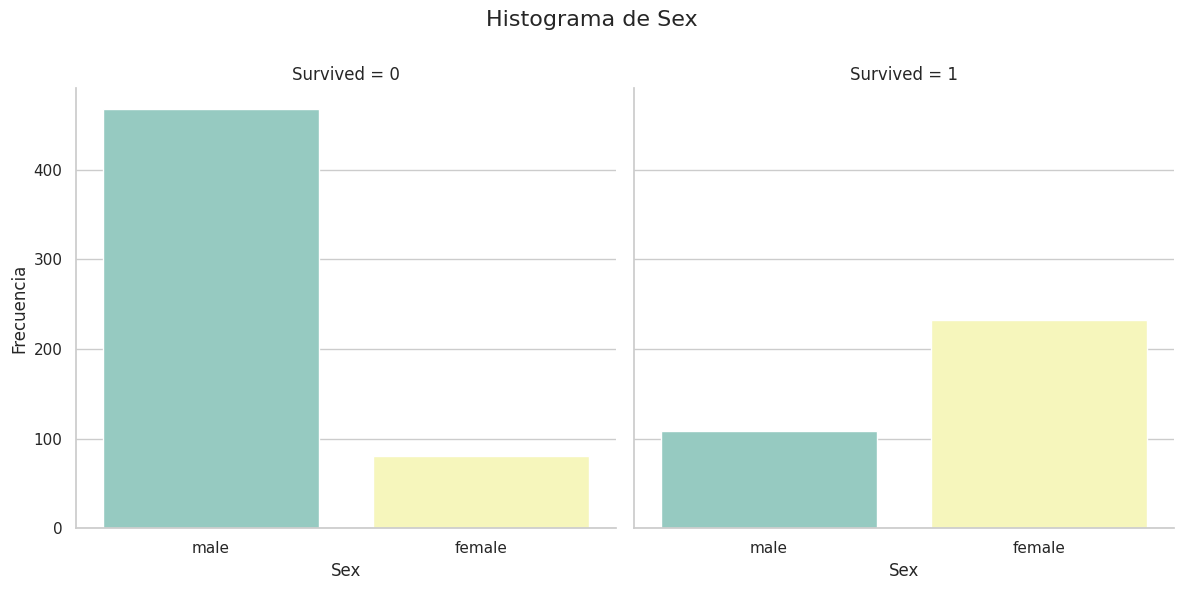

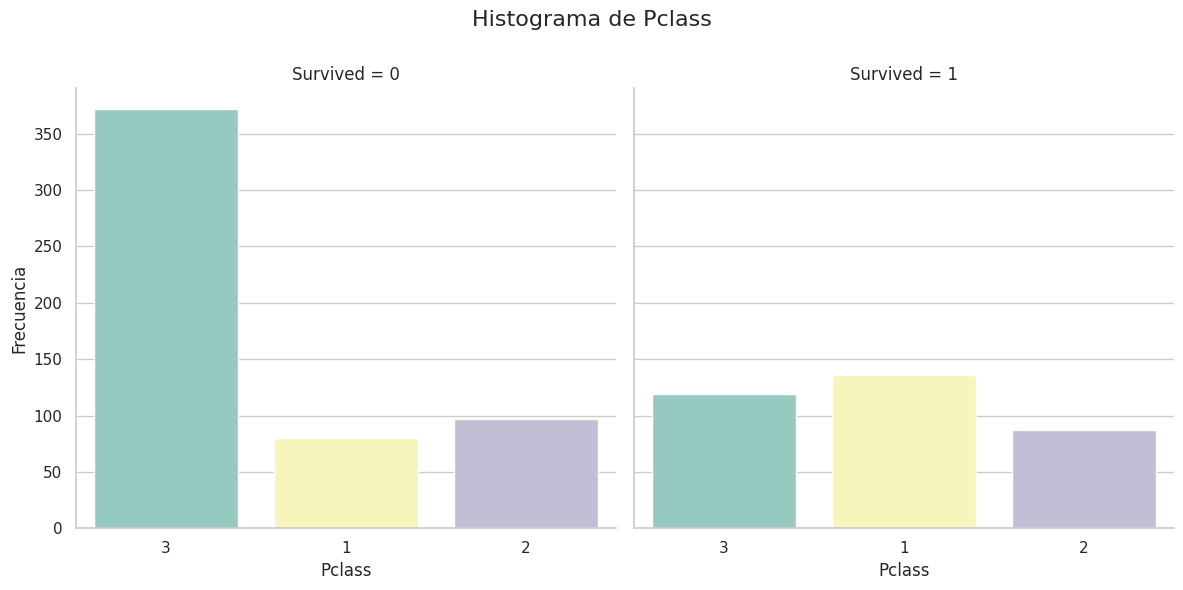

In [118]:
# Filter out unwanted columns
filtered_cols = [col for col in variables_cualitativas.columns if col not in ['Name', 'Ticket', 'Cabin', 'Embarked', 'Survived']]

# Iterate through filtered columns
for variable in filtered_cols:
    # Create a FacetGrid with a larger height
    g = sns.FacetGrid(train_df, col='Survived', height=6)

    # Map a countplot for the current variable and specify the order
    g.map(sns.countplot, variable, palette='Set3', order=train_df[variable].value_counts().index)

    # Set a title for the current plot
    plt.subplots_adjust(top=0.85)  # Adjust the title position
    g.fig.suptitle(f'Histograma de {variable}', fontsize=16)
    g.set_axis_labels(variable, 'Frecuencia')

# Show the plots
plt.show()

**Observaciones:**
- Aproximadamente, 20% de los hombres sobrevivieron. Por otro lado, aproximandamente el 75% de las mujeres sobrevivieron.
- Sólo sobrevivió un tercio de los pasajeros de tercera clase y la mitad de los de primera. Por otro lado, los de segunda clase tienen casi la misma proporcion para ambos casos.
- Faltan algunas variables de graficar pero primero tiene que pasar por un proceso de transformación.

In [119]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 2.3 Conclusiones

Se puede conluir que los puntos de apoyo para el posterior proceso de transformación de datos seran los siguientes:
- Valores nulos de **Age** (19.87%), **Cabin** (77.10%) y **Embarked** (0.22%).
- **SibSp** y **Parch** no parecen ser tan diferentes.
- El mínimo para los valores de **Fare** es cero.
- Valores únicos para **Name** y **PassengerId**.
- Valores únicos para **Ticket** (23.57%) y **Cabin** (27.94%).
- **Sex**, **Embarked**, **Survived**, y **Pclass** cuentan con muy pocos valores únicos.
- **Parch** (23.91%) y **Fare** (13.02%) tienen datos atípicos.
- **SibSp** (5.16%) y **Age** (1.23%) tienen un porcentaje más bajo de datos atípicos.
- Simetría y formas de la distribución para variables cuantiativas.
- Tasa de supervivencia por sexo y clase.
- Faltan algunas variables por graficar.

### 3. Transformación (Transform)

El proceso de transformación en ETL es una fase fundamental en la gestión de datos y se encarga de limpiar, estructurar y enriquecer los datos extraídos de múltiples fuentes antes de cargarlos en un almacén de datos o un sistema destino. En esta fase se garantiza que los datos sean coherentes, útiles y estén listos para su posterior uso dentro del modelo.

Para llevar a cabo este proceso las siguientes tareas se tomaran en cuenta:
1. Identificación y eliminación de duplicados.
2. Detección y manejo de valores nulos o faltantes.
3. Codificación de variables categóricas y discretización.
4. Ingeniería inversa para crear variables.
5. Eliminación de atributos.

Este proceso se aplicará tanto en el subconjunto de entrenamiento (train_df) como en el de prueba (test_df).

#### 3.1 Identificación y eliminación de duplicados
Considerando que la eliminación y gestión adecuada de duplicados puede tener un impacto significativo en la calidad y la integridad de los datos se realizó una revisión sobre los siguientes elementos: registros, identificadores de pasajeros, nombres y tickets.

In [120]:
def check_duplicates(dataframe, columns_to_check, dataframe_name):
    print(f"{dataframe_name} dataframe")

    # Verificar registros duplicados
    duplicados = dataframe[dataframe.duplicated()]
    if len(duplicados) > 0:
        print(f"Registros duplicados encontrados: {len(duplicados)}.")
    else:
        print("No se encontraron duplicados en registros.")

    # Verificar registros de variables duplicados
    for column_name in columns_to_check:
        duplicate_rows = dataframe[dataframe.duplicated(subset=[column_name])]

        if duplicate_rows.shape[0] > 0:
            print(f"{column_name} duplicados encontrados: {len(duplicate_rows)}.")
        else:
            print(f"No se encontraron duplicados en {column_name}.")

# Lista de columnas que deseas verificar
columns_to_check = ['PassengerId', 'Name', 'Ticket']

check_duplicates(train_df, columns_to_check, 'Train')
print("\n")
check_duplicates(test_df, columns_to_check, 'Test')

Train dataframe
No se encontraron duplicados en registros.
No se encontraron duplicados en PassengerId.
No se encontraron duplicados en Name.
Ticket duplicados encontrados: 210.


Test dataframe
No se encontraron duplicados en registros.
No se encontraron duplicados en PassengerId.
No se encontraron duplicados en Name.
Ticket duplicados encontrados: 55.


**Observación:** El único elemento en el que se identificaron duplicados es "tickets". Esto indica que algunos pasajeros tienen el mismo ticket. Dentro del contexto del problema esto puede significar, bajo la suposición de que cada ticket debería de ser único, que hubo algún error al registrar los tickets para cada pasajero. Además, considerando que el modelo utilizado trabajará sobre valores numéricos, los valores de la variable no aportarian mucho después de una transformación a valores numéricos. Por lo tanto, **Ticket** se elimina de la base de datos.

In [121]:
# Eliminar Ticket de dataframes
def eliminar_tickets(dataframe):
  dataframe.drop('Ticket', axis=1, inplace=True)
  return dataframe

train_df = eliminar_tickets(train_df)
test_df = eliminar_tickets(test_df)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


#### 3.2 Detección y manejo de valores nulos o faltantes

Para asegurar una limpieza y mantenimiento correcto de la información se revisan cúales atributos pueden tener datos nulos con fin de ver si es posible modificar los datos o descartarlos.

In [122]:
# Funcion que identifica la cantidad de valores nulos por atributo de dataframe
def identificar_nulos(dataframe, dataframe_name):
  print(dataframe_name + " dataframe")
  print(dataframe.isnull().sum())

identificar_nulos(train_df, "Train")
print("\n")
identificar_nulos(test_df, "Test")

Train dataframe
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Test dataframe
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
dtype: int64


**Observaciones**:
- Las observaciones de valores nulos realizada anteriormente coincide con los resultados presentes en el subconjunto de entrenamiento.
- En el subconjunto de prueba se tienen valores nulos para **Age**, **Fare** y **Cabin**.
- Bajo estos hechos se puede asumir que para una muestra aleatoria del conjunto de datos del Titanic es posible que en las siguientes variables poseean valores nulos: **Cabin**, **Age**, **Embarked** y **Fare**.

**¿Qué se puede hacer con estos valores nulos?**
- Reemplazar los valores por un promedio para **Age**, **Embarked** y **Fare**.
- Eliminar la variable **Cabin**, debido a su gran cantidad de valores nulos.

##### 3.2.1 Reemplazo de valores nulos por promedio

In [123]:
# AGE
def reemplazar_nulos_age(dataframe):
  # Calcula el promedio de edad por titulo
  dataframe_sin_nulos = dataframe.dropna(subset=["Age"]).copy()
  dataframe_sin_nulos["Title"] = dataframe_sin_nulos["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
  average_age_by_title = dataframe_sin_nulos.groupby("Title")["Age"].mean()
  average_age_by_title = average_age_by_title.to_dict()

  # Reemplazan los datos nulos por el promedio de edad por titulo
  dataframe["Title"] = dataframe["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
  dataframe["Age"].fillna(dataframe["Title"].map(average_age_by_title), inplace=True)

  # Calcula el promedio de edad global
  dataframe_sin_nulos = dataframe.dropna(subset=["Age"]).copy()
  mean_age = dataframe_sin_nulos["Age"].mean()

  # Reemplazan los datos nulos restantes por el promedio de edad global
  dataframe["Age"].fillna(mean_age, inplace=True)

  return dataframe

train_df = reemplazar_nulos_age(train_df)
test_df = reemplazar_nulos_age(test_df)

identificar_nulos(train_df, "Train")
print("\n")
identificar_nulos(test_df, "Test")

Train dataframe
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64


Test dataframe
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64


In [124]:
# EMBARKED
def reemplazar_nulos_embarked(dataframe):
  # Filtra el DataFrame para obtener solo las filas con valores no nulos.
  dataframe_sin_nulos = dataframe.dropna(subset=["Embarked"]).copy()
  # Usar el método mode() para obtener la moda de la columna 'Embarked'
  moda = dataframe_sin_nulos['Embarked'].mode().iloc[0]
  # Fill NaN values in the "Embarked" column with the mean value
  dataframe["Embarked"].fillna(moda, inplace=True)
  return dataframe

train_df = reemplazar_nulos_embarked(train_df)
test_df = reemplazar_nulos_embarked(test_df)

identificar_nulos(train_df, "Train")
print("\n")
identificar_nulos(test_df, "Test")

Train dataframe
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64


Test dataframe
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64


In [125]:
# FARE
def reemplazar_nulos_fare(dataframe):
  # Filtra el DataFrame para obtener solo las filas con valores no nulos.
  dataframe_sin_nulos = dataframe.dropna(subset=["Fare"]).copy()
  # Usar el método mode() para obtener la moda de la columna 'Embarked'
  mean = dataframe_sin_nulos["Fare"].mean()
  # Fill NaN values in the "Embarked" column with the mean value
  dataframe["Fare"].fillna(mean, inplace=True)
  return dataframe

train_df = reemplazar_nulos_fare(train_df)
test_df = reemplazar_nulos_fare(test_df)

identificar_nulos(train_df, "Train")
print("\n")
identificar_nulos(test_df, "Test")

Train dataframe
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64


Test dataframe
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64


##### 3.2.2 Eliminación de la variable **Cabin**

In [126]:
# Eliminar Ticket de dataframes
def eliminar_cabin(dataframe):
  dataframe.drop('Cabin', axis=1, inplace=True)
  return dataframe

train_df = eliminar_cabin(train_df)
test_df = eliminar_cabin(test_df)

identificar_nulos(train_df, "Train")
print("\n")
identificar_nulos(test_df, "Test")

Train dataframe
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64


Test dataframe
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64


#### 3.3 Codificación de variables categóricas y discretización

Para que el modelo por implementar funcione es necesario convertir todos los valores de las variables categóricas a valores numéricos. Además, para mejorar su desempeño conviene homogeneizar los datos de todas las variables.

##### 3.3.1 Conversión de variables categóricas a valores numéricos

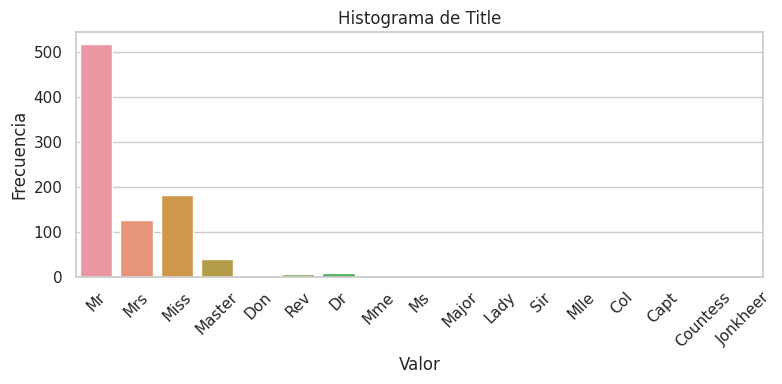

In [127]:
plt.figure(figsize=(8, 4))  # Set the figure size as per your preferences

# Create a bar plot using Seaborn
sns.countplot(data=train_df, x='Title')

# Add a title for each plot
plt.title('Histograma de Title')

# Axis labels
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

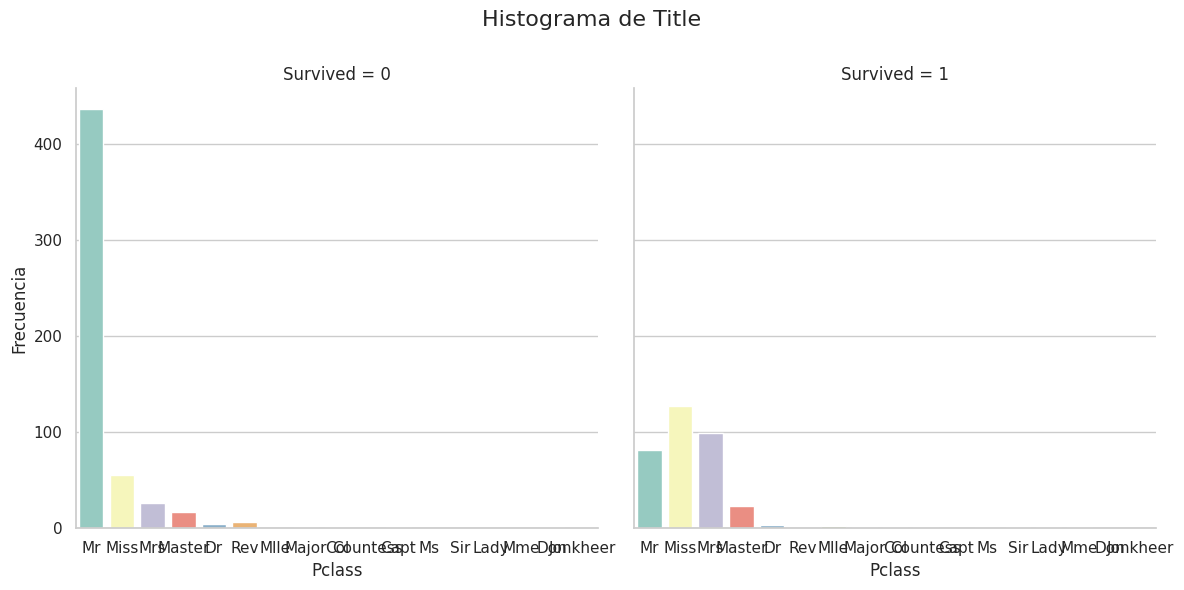

In [128]:
# Create a FacetGrid with a larger height
g = sns.FacetGrid(train_df, col='Survived', height=6)

# Map a countplot for the current variable and specify the order
g.map(sns.countplot, 'Title', palette='Set3', order=train_df['Title'].value_counts().index)

# Set a title for the current plot
plt.subplots_adjust(top=0.85)  # Adjust the title position
g.fig.suptitle('Histograma de Title', fontsize=16)
g.set_axis_labels(variable, 'Frecuencia')
plt.show()

In [129]:
def convertir_variables_categoricas(dataframe):
  # Mapeo de valores en la columna 'Sex' a valores enteros
  mapeo_sexo = {'male': 1, 'female': 0}
  dataframe['Sex'] = dataframe['Sex'].map(mapeo_sexo)

  # Mapeo de valores en la columna 'Embarked' a valores enteros
  mapeo_embarcada = {'C': 1, 'S': 2, 'Q': 3}
  dataframe['Embarked'] = dataframe['Embarked'].map(mapeo_embarcada)

  # Replace titles not in the valid_titles list with 'Other'
  valid_titles = ['Mr', 'Mrs', 'Miss', 'Master']
  dataframe['Title'] = dataframe['Title'].apply(lambda x: x if x in valid_titles else 'Other')

  # Mapeo de valores en la columna 'Embarked' a valores enteros
  mapeo_embarcada = {'Mr': 1, 'Mrs': 2, 'Miss': 3, 'Master': 4, 'Other': 5}
  dataframe['Title'] = dataframe['Title'].map(mapeo_embarcada)

  return dataframe

train_df = convertir_variables_categoricas(train_df)
test_df = convertir_variables_categoricas(test_df)

##### 3.3.2 Discretización de variables

In [130]:
splits = 5  # Número de divisiones

# Función para discretizar y llenar valores nulos
def discretize_and_fillna(df, column_name):
    df[column_name] = pd.qcut(df[column_name], splits, labels=False, duplicates='drop').fillna(5).astype(int) + 1

# Aplicar la función a 'Fare' y 'Age' en train_df
discretize_and_fillna(train_df, 'Fare')
discretize_and_fillna(train_df, 'Age')

# Aplicar la misma función a 'Fare' y 'Age' en test_df
discretize_and_fillna(test_df, 'Fare')
discretize_and_fillna(test_df, 'Age')

In [131]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,1,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,4,1,0,5,1,2
2,3,1,3,"Heikkinen, Miss. Laina",0,2,0,0,2,2,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,5,2,2
4,5,0,3,"Allen, Mr. William Henry",1,4,0,0,2,2,1


#### 3.4 Ingeniería inversa para crear variables

In [132]:
# Crear variable de isAlone
def ingenieria_inversa_isalone(dataframe):
  dataframe['Fam'] = dataframe['SibSp'] + dataframe['Parch']
  dataframe['IsAlone'] = (dataframe['Fam'] == 0).astype(int)
  dataframe.drop('Fam', axis=1, inplace=True)
  return dataframe

train_df = ingenieria_inversa_isalone(train_df)
test_df = ingenieria_inversa_isalone(test_df)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,2,1,0,1,2,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,4,1,0,5,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,2,0,0,2,2,3,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,5,2,2,0
4,5,0,3,"Allen, Mr. William Henry",1,4,0,0,2,2,1,1


#### 3.5 Eliminación de atributos

Los atributos que consideramos eliminar de nuestros conjuntos de datos son los siguientes:
* Name: No lo necesitamos para el modelo debido a que no tiene una directa correlación con la supervivencia de los pasajeros. Se podría utilizar como identificador de los registros, pero para esto ya tenemos el atributo "PassengerId".
* Title: Solo lo necesitamos para estimar la edad para los pasajeros que no tenían registrado este atributo y reemplazar los valores nulos de acuerdo a este estimado.
* Cabin: No conviene utilizarlo debido a su gran porcentaje de valores nulos. En el dataset de entrenamiento el 77.1% de sus valores son nulos, mientras que en el dataset de prueba correponde a 78.2%. Además, los valores de esta columna son cadenas de texto que difícilmente se pueden traducir a un valor numérico.
* Ticket: No conviene utilizarlo debido a que es un valor con tipos de datos mezclados y no se puede simplificar a un valor numérico. Además cuenta con un considerabel porcentaje de valores nulos y no creemos que tenga una correlación directa con la supervivencia de los pasajeros.

In [133]:
def eliminar_variables(dataframe, name_df):
  if name_df == "Train":
    dataframe = dataframe.drop(['Name', 'PassengerId', 'SibSp', 'Parch'], axis='columns')
  else:
    dataframe = dataframe.drop(['Name', 'SibSp', 'Parch'], axis='columns')

  return dataframe

train_df = eliminar_variables(train_df, "Train")
test_df = eliminar_variables(test_df, "Test")

test_df


,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,1,4,2,3,1,1
1,893,3,0,5,1,2,2,0
2,894,2,1,5,2,3,1,1
3,895,3,1,3,2,2,1,1
4,896,3,0,2,3,2,2,0
...,...,...,...,...,...,...,...,...
413,1305,3,1,3,2,2,1,1
414,1306,1,0,4,5,1,5,1
415,1307,3,1,4,1,2,1,1
416,1308,3,1,3,2,2,1,1


In [134]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,2,1,2,1,0
1,1,1,0,4,5,1,2,0
2,1,3,0,2,2,2,3,1
3,1,1,0,4,5,2,2,0
4,0,3,1,4,2,2,1,1


### 4. Exportar datos (Load)

In [135]:
# Organizar columnas de los dataframes
orden_train = ['Pclass', 'Age', 'Sex', 'IsAlone', 'Fare', 'Embarked', 'Title', 'Survived']
orden_test = ['PassengerId', 'Pclass', 'Age', 'Sex', 'IsAlone', 'Fare', 'Embarked', 'Title']
train_df = train_df[orden_train]
test_df = test_df[orden_test]

# Guardar a archivo csv
train_df.to_csv('train_etl.csv', index=False)
test_df.to_csv('test_etl.csv', index=False)

print("Archivos CSV guardados exitosamente.")

Archivos CSV guardados exitosamente.


## **Evidencia 2: Selección, configuración y entrenamiendo del modelo**
En esta sección se presenta la selección, configuración y entrenamiento de los modelos candidatos que resolverán la problemática planteada en la introducción de este documento. A continuación, se muestran los procesos de selección, configuración y entrenamiento de cada uno de ellos.

In [136]:
# Uso general
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Division de subconjuntos y escalamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelo
from sklearn.neighbors import KNeighborsClassifier

# Metricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [137]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/train_etl.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/test_etl.csv')

#Descripcion de datos de entrenamiento
cantidad_registros = len(train_df)
numero_caracteristicas = len(train_df.columns) - 1
valores_salida = train_df["Survived"].unique()
print("Descripcion de Training ETL Titanic Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")

#Descripcion de datos de prueba
cantidad_registros = len(test_df)
numero_caracteristicas = len(test_df.columns) - 1
print("Descripcion de Testing ETL Titanic Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: Ninguno.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descripcion de Training ETL Titanic Dataset
Cantidad de registros: 891
Número de características: 7
Valores de salida: [0 1]
Descripcion de Testing ETL Titanic Dataset
Cantidad de registros: 418
Número de características: 7
Valores de salida: Ninguno.


### Separación de datos en subconjuntos

Para entrenar al modelo se dividen los datos en los subconjuntos de entrenamiento y vaidación en una proporción de sesenta y cuarenta respectivamente. Para realizar este división se utiliza la función **train_test_split**, la cual selecciona las muestras para cada subconjunto aleaoriamente.

In [138]:
# Seleccion de columnas de train_df
n = len(train_df.columns) - 1
X = train_df.iloc[:, 0:n]
y = train_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (60%) y prueba (40%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

### 1. Selección del Modelo

#### 1.1 Random Forest

Dentro de este codigo se incorpora una solucion para crear un modelo tipo Random Forest para predecir si un pasajero sobrevive o no. A continuacion se explica el proceso por medio de comentarios y estrucutra de codigo para eficientar el aprendizaje del modelo y sus caracterisicas. La razon por la que se escogio este dataset fue por el motivo de que ya tenemos el ETL para analizar los datos de forma mas organizada y asi llevar a tener mejores resultados. Los datos transformados se encuentran en el archivo train_etl y test_etl. Usaremos esta informacion para alimentar el modelo y finalmente usaremos tests para probarlo.

La referencia para hacer este modelo se compoarte en la siguiente liga: https://machinelearningmastery.com/implement-random-forest-scratch-python/

Liga del dataset (No incluye el proceso de ETL): https://www.kaggle.com/competitions/titanic

Nota: En caso de correr el codigo localmente asegurarse de tener el ruteo y la direccion correta de los archivos train_etl.csv y test_etl.csv.

Vamos a estar usando varios decision trees. El objetivo es combinarlos y agregar las predicciones para tomar una decision final.

Este modelo fue realizado por: Rodolfo Sandoval, miembro del equipo 7 del curso TC3006C.101.

##### 1.1.1 Descripción del modelo
El random forest classifier es un modelo utilizado para problemas de clasificación y de regresión. Es un modelo que involucra el conjunto de varios árboles de decisión para aumentar la precisión y los resultados del modelo. El modelo de random forest se enfoca en la división de datos de entrenamiento y de prueba. En este caso, la división de datos es distribuida con el ETL, tal que podemos analizar los casos prueba y los resultados dentro de un mismo archivo.

El modelo de random forest calcula la impureza gini para medir que tan mezcladas están las clases dentro de un conjunto de datos. Luego se hace la división en dos subconjuntos según el valor umbral para obtener valores menores o iguales y otro subconjunto para los valores mayores al umbral.

Finalmente se hace la construcción del árbol, que construye un árbol de acuerdo a las divisiones utilizadas. Si se alcanza una profundidad máxima o si todas las etiquetas son iguales, se crea un nodo con la clase más frecuente. Si no, sigue dividiendo el conjunto de datos en subconjuntos más pequeños y construyendo el árbol. Luego, hacemos la construcción del random forest para construir múltiples árboles de decisión usando subconjuntos aleatorios del entrenamiento. Cada árbol se construye con una profundidad máxima y se agrega al bosque.

##### 1.1.2 ¿Porqué se seleccionó como modelo?

Se seleccionó debido a la precisión y generalización de los resultados. Esto es debido a que al combinar múltiples árboles de decisión, el modelo puede ser menos propenso al overfitting. Esto nos permite manejar características irrelevantes en el conjunto de datos y es seleccionado debido a que se proporciona información de importancia de cada característica en la toma de decisiones. Debido a esto, tuvimos que incorporar el proceso de ETL para mejorar el rendimiento y la eficiencia del modelo. Cuyo, afecta la toma de decisión y aumenta la significancia del valor dado y su precisión.

##### 1.1.3 Metodología utilizada para construir el modelo

La metodología se explica en el punto **1.1.1** Sin embargo, es importante notar que también se calcula la precisión del cálculo comparando las predicciones del random forest con las etiquetas reales en el conjunto de prueba. La precisión es dividida por el número de predicciones correctas entre el número total de muestras. Estos resultados los guardamos dentro de un archivo csv para comparar si el pasajero sobrevivió o no.

##### 1.1.4 Entrenamiento del modelo

In [139]:
# Funcion para calcular la impureza Gini
def gini_impureza(etiquetas):
    clases_unicas, counts = np.unique(etiquetas, return_counts=True) #Encontramos las clases unicas
    clases_prob = counts / len(etiquetas) #Calculamos las probabilidades de las clases en relacion a la longitud total de etiquetas
    gini = 1 - np.sum(clases_prob ** 2) #Calculamos la impuresa de Gini (con esto determinamos como dividir los datos en los nodos del arbol)
    return gini

# Funcion para dividir los datos en funcion de un valor de umbral data = datos, feature_idx = indice donde se basa la division, y umbral = el valor umbral que se realiza para la division
def split_data(data, feature_idx, umbral):
    izq = data[data[:, feature_idx] <= umbral] #subconjunto con los valores sean menor o iguales al umbral
    derecha = data[data[:, feature_idx] > umbral] #subconjunto cuando sean mayores al umbral
    return izq, derecha

# Funcion para encontrar la mejor division para un conjunto de datos
def find_best_split(data):
    best_gini = float("inf") # Inicializar con un valor alto para comparacion
    best_feature_idx = None
    best_umbral = None

    num_features = data.shape[1] - 1 #Restamos la columna que incluye etiquetas

#Iteramos sobre las caracteristicas
    for feature_idx in range(num_features):
        unique_values = np.unique(data[:, feature_idx])
        for umbral in unique_values: #Sobre valores unicos
            izq, derecha = split_data(data, feature_idx, umbral)
            if len(izq) > 0 and len(derecha) > 0: # Dividir los datos en dos subconjuntos: izquierdo y derecho
                gini_izq = gini_impureza(izq[:, -1]) #Calcular impureza gini para lado izquierdo
                gini_derecha = gini_impureza(derecha[:, -1]) #Calcular impureza gini para lado derecho
                weighted_gini = (len(izq) / len(data)) * gini_izq + (len(derecha) / len(data)) * gini_derecha #Caclular la impureza despues de la division

                if weighted_gini < best_gini: #Checar si se encuentra una mejor division y replazar esos valores
                    best_gini = weighted_gini
                    best_feature_idx = feature_idx
                    best_umbral = umbral

    return best_feature_idx, best_umbral

# Funcion para construir un arbol de decision
def build_tree(data, max_depth):
    if max_depth == 0 or len(np.unique(data[:, -1])) == 1: #Checar si max_depth (profundidad de los nodos) es 0 o sin las etiquetas son iguales con unique
        clases_unicas, counts = np.unique(data[:, -1], return_counts=True)
        return clases_unicas[np.argmax(counts)]

    best_feature_idx, best_umbral = find_best_split(data)

    # Sacar la clase mayoritaria en caso de que no sea posible hacer una division (Clase con mayor cantidad de ejemplos)
    if best_feature_idx is None:
        clases_unicas, counts = np.unique(data[:, -1], return_counts=True)
        return clases_unicas[np.argmax(counts)]

    # Dividir los datos en dos subconjuntos usando la mejor caracteristica y umbral
    izq, derecha = split_data(data, best_feature_idx, best_umbral)
    izq_subtree = build_tree(izq, max_depth - 1)
    derecha_subtree = build_tree(derecha, max_depth - 1)
    return (best_feature_idx, best_umbral, izq_subtree, derecha_subtree) #Retornamos un nodo arbol con la mejor caracteristica

# Funcion para construir un Random Forest
def build_random_forest(data, num_arboles, max_depth):
    forest = [] #Lista de los arboles del bosque
    for _ in range(num_arboles):
        subset = np.random.choice(len(data), size=len(data), replace=True) #Creamos subconjunto aleatorio con replace para el conjunto de datos
        subset_data = data[subset]
        tree = build_tree(subset_data, max_depth) #Contruimos un arbol aleatorio
        forest.append(tree) #Agregamos el arbol al bosque
    return forest

# Funcion para hacer predicciones usando un arbol de decision
def predict(tree, sample):
    if isinstance(tree, np.int64):  # Si el nodo actual es una clase, devuelve la clase predicha
        return tree

    feature_idx, umbral, izq_subtree, derecha_subtree = tree

    if sample[feature_idx] <= umbral: # Comparamos el valor de la caracteristica (feature_idx) de la muestra con el umbral
        return predict(izq_subtree, sample) #Si es menor o igual al umbral nos vamos por el subarbol izq
    else:
        return predict(derecha_subtree, sample) #Si mayor al umbral nos vamos por el subarbol derecho

# Funcion para hacer predicciones con el Random Forest
def predict_random_forest(forest, sample):
    predi = [predict(tree, sample) for tree in forest]
    return np.bincount(predi).argmax()

train_data = np.column_stack((X_train, y_train))
validation_data = np.column_stack((X_val, y_val))

# Convertir los conjuntos X_train y y_train a arreglos NumPy para facilitar su manejo
train_data = np.column_stack((X_train, y_train))
num_arboles = 100
max_depth = 3
forest = build_random_forest(train_data, num_arboles, max_depth)


##### 1.1.5 Análisis de desempeño

**Métricas de desempeño para subconjuntos de entrenamiento y validación**

Para evaluar el desempeño del **clasificador de bosque aleatorio** se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [140]:
# Hacer predicciones en datos de validacion
y_pred_val = [predict_random_forest(forest, sample) for sample in validation_data[:, :-1]]
actual_etiquetas_val = validation_data[:, -1]

# Hacer predicciones en datos de entrenamiento
y_pred_train = [predict_random_forest(forest, sample) for sample in train_data[:, :-1]]
actual_etiquetas_train = train_data[:, -1]

def metricas_desempeno(y, y_pred):
  confusion_matrix_results = confusion_matrix(y, y_pred)
  accuracy_score_results = accuracy_score(y, y_pred)
  precision_score_results = precision_score(y, y_pred)
  recall_score_results = recall_score(y, y_pred)
  f1_score_results = f1_score(y, y_pred)
  return confusion_matrix_results, accuracy_score_results, precision_score_results, recall_score_results, f1_score_results

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, y_pred_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, y_pred_val)

# Create a DataFrame to display the metrics
rfc_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

rfc_metrics_df

,Metric,Train,Validation
0,Accuracy,0.835206,0.806723
1,Precision,0.815642,0.795082
2,Recall,0.726368,0.687943
3,F1 Score,0.768421,0.737643


**Matriz de confusión**

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

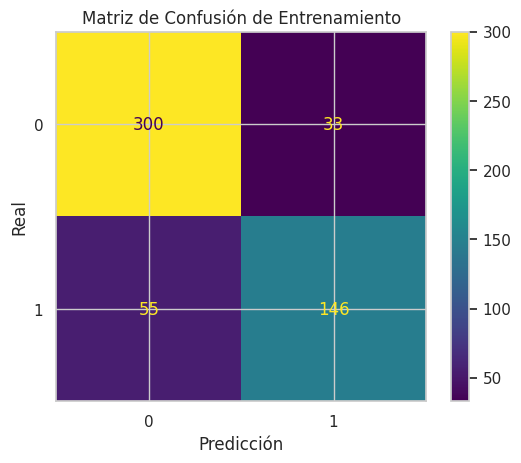

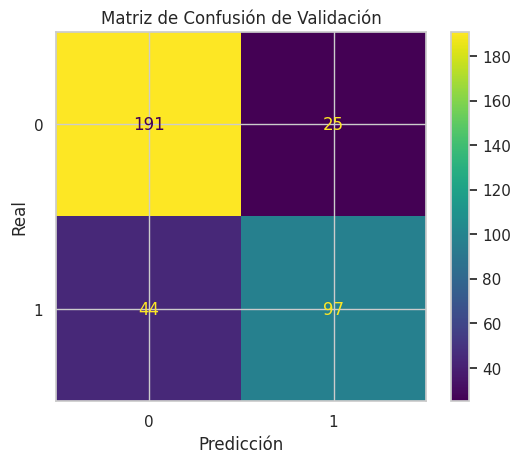

In [141]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validacion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

**Predicciones con modelo entrenado**

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [142]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

random_indices = random.sample(range(n_samples), min(3, n_samples))

# Asegurarse de que los índices seleccionados estén dentro del rango válido
random_indices = [idx for idx in random_indices if idx < n_samples]

# Obtener las muestras de X_val y y_val utilizando los índices seleccionados
three_X_samples = [X_val.iloc[i] for i in random_indices]
three_y_samples = [y_val.iloc[i] for i in random_indices]

# Realizar las predicciones en las muestras seleccionadas
pred_puntuales = [predict_random_forest(forest, sample) for sample in three_X_samples]

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Predicción': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
print(resultado_df)

   Real  Predicción
0     0           0
1     1           0
2     0           0


#### 1.2 Clasificador KNN

Para más información sobre la implementación favor de consultar el reporte final del reto en la sección **Selección, Configuración y Entrenamiento del Modelo**. El reporte esta ubicado en el repositorio en la carpeta llamada Modelos, junto con las carpetas de cada modelo. El nombre del archivo es: ReporteFinal_Equipo7.pdf. También se puede consultar por medio del siguiente link: https://docs.google.com/document/d/199vDBFCTWJKEMpJC6qNKBOe6Gf4dxnn06aPI6NvIPmA/edit?usp=sharing

Este modelo fue realizado por: Arturo Garza Campuzano, miembro del equipo 7 del curso TC3006C.101.

##### 1.2.1 Descripción del modelo
El algoritmo de k vecinos más cercanos (KNN) es un algoritmo clasificador de aprendizaje de máquina supervisado no paramétrico que utiliza la proximidad para hacer clasificaciones o predicciones sobre la agrupación de un punto de datos individual (IBM, s.f.).

El proceso del algoritmo se resumen en los siguientes pasos:
1. Elección del número de k y una métrica de distancia.
2. Encontrar los k vecinos más cercanos de la muestra que se quiere clasificar.
3. Asignar la etiqueta de clase por mayoría de votos.

KNN es un modelo de aprendizaje perezoso, lo cual indica que no aprende una función discriminativa en el conjunto de datos de entrenamiento, sino que memoriza este mismo conjunto.

La principal ventaja de este enfoque basado en la memoria es que el clasificador se adapta inmediatamente a medida que se recopilan nuevos datos de entrenamiento. Sin embargo, la desventaja es que la complejidad computacional para clasificar nuevas muestras crece linealmente con el número de muestras del conjunto de datos de entrenamiento en el peor de los casos, a menos que el conjunto de datos tenga muy pequeñas dimensiones (características) y el algoritmo se haya implementado utilizando estructuras de datos eficientes como árboles KD (Sebastian Raschka, 2015).

**¿Cómo se define el valor de k en nuestro modelo?**

En realidad, no se tiene una regla definida para encontrar el valor más óptimo para k vecinos. No obstante, se sabe que su adecuada elección es crucial para encontrar un buen balance entre subajuste y sobreajuste (Sebastian Raschka, 2015). También es importante encontrar la métrica de distancia apropiada para los atributos del conjunto de datos objetivo.

Cabe mencionar que en algunos recursos audiovisuales se encontraron los siguientes criterios para aproximarnos al valor ideal de k:
1. El valor de k puede ser estimado por medio de la siguiente fórmula: $k = \sqrt{n}$. Donde n es el número total de datos puntuales.
2. Se recomienda utilizar un valor impar para k para efectos de facilitar el proceso de votación.
3. Procurar que el valor de k no sea muy pequeño ni muy grande.


##### 1.2.2 ¿Porqué se seleccionó como modelo?
Su selección se basa en las siguientes observaciones del conjunto de datos:
1. El tamaño del conjunto no es tan grande.
2. Cuenta con muy pocas características a comparación de otros conjuntos de datos populares.


##### 1.2.3 Metodología utilizada para construir el modelo
La metodología utilizada para la construcción del modelo fue la siguiente:
1. Investigación del algoritmo KNN
2. Implementación del algoritmo sobre otros conjuntos de datos
3. Implementación del algoritmo sobre la problemática del Titanic


##### 1.2.4 Entrenamiendo del modelo

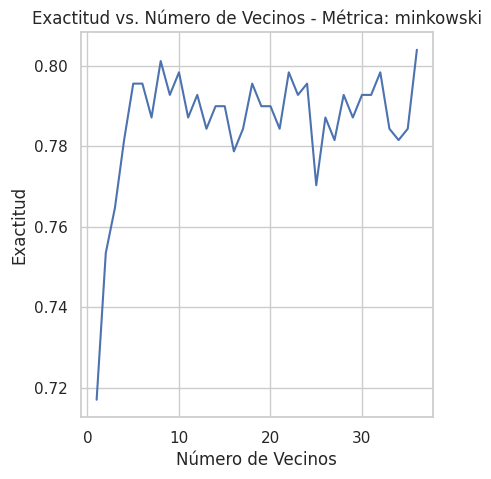

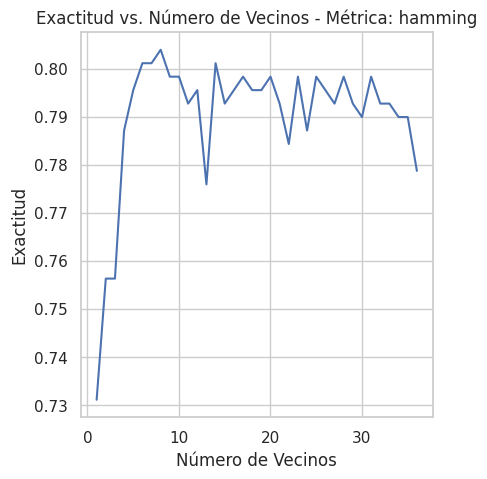

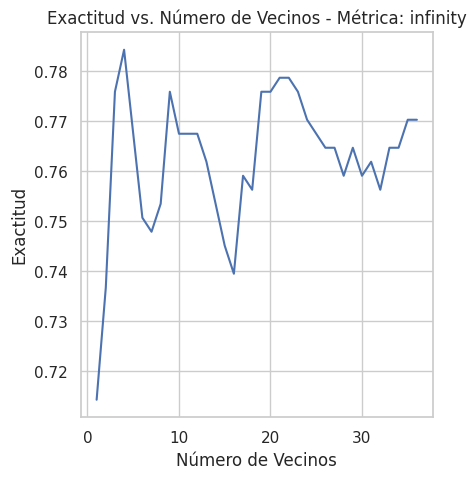

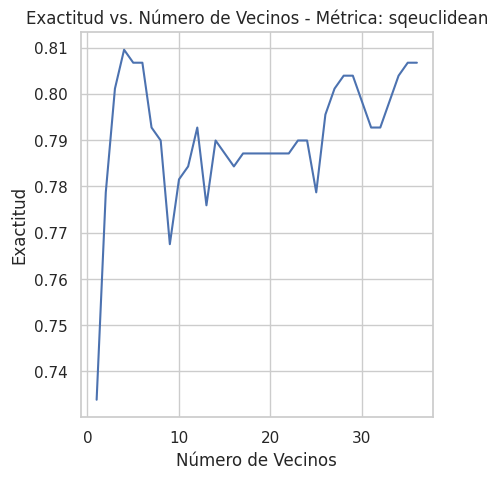

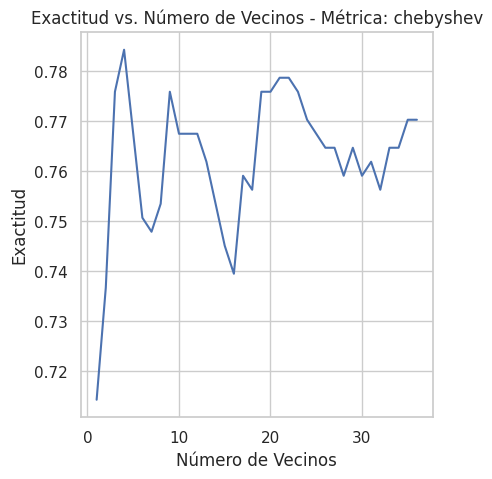

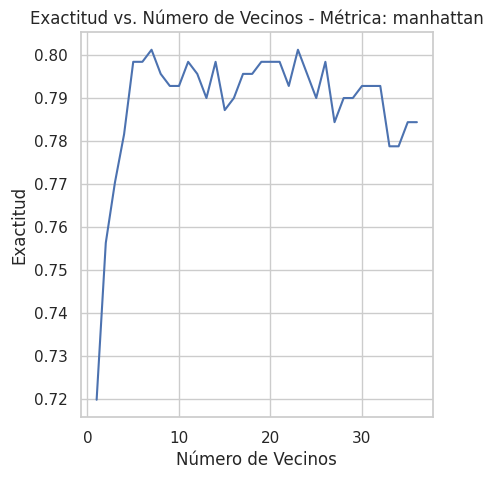

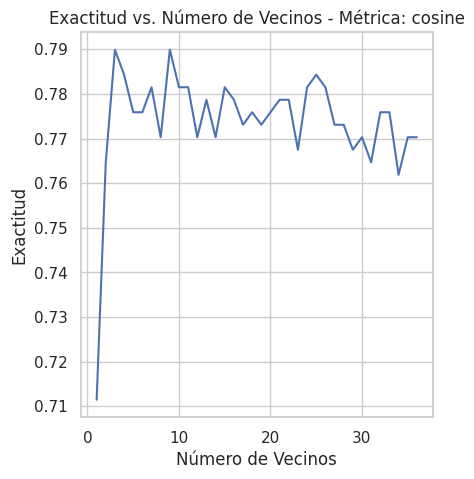

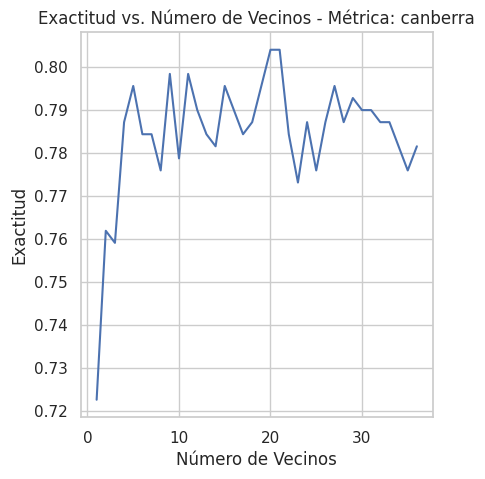

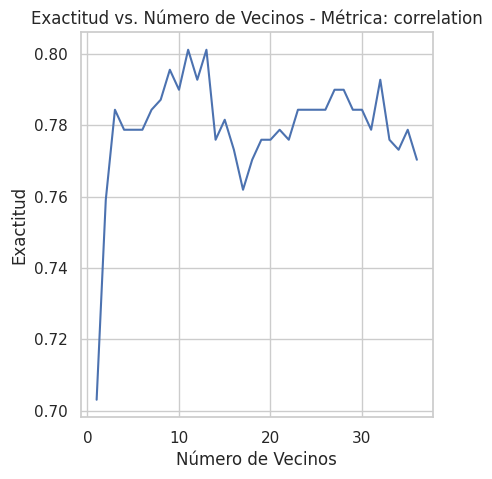

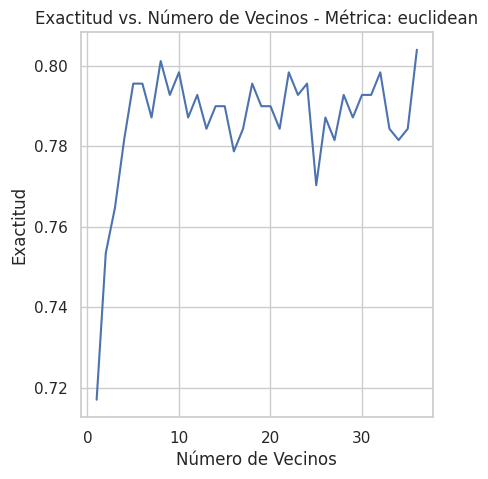

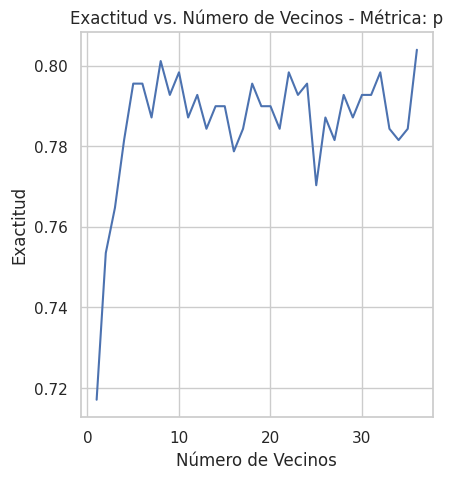

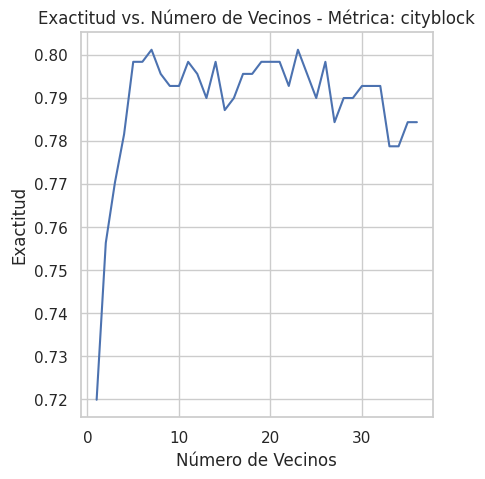

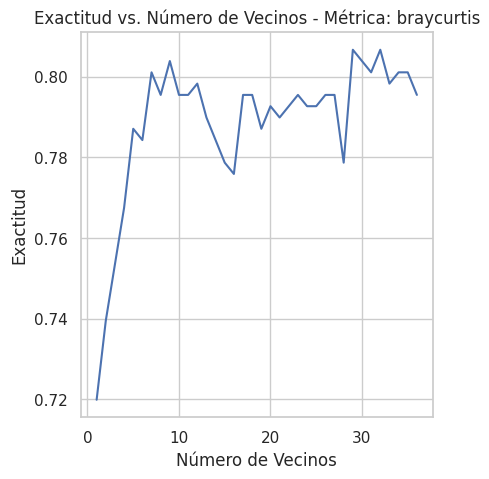

In [143]:
# Definir una funcion para entrenar y evaluar el modelo
def train_and_evaluate_model(X_train, y_train, X_val, y_val, metrica, n_range):
    accuracy_array = []
    train_errors = []
    val_errors = []

    for i in n_range:
        classifier = KNeighborsClassifier(n_neighbors=i, metric=metrica)
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_val)
        # Predecir en el conjunto de entrenamiento y validación
        y_train_pred = classifier.predict(X_train)
        y_val_pred = classifier.predict(X_val)

        accuracy_score_temp = accuracy_score(y_val, y_pred)

        # Calcular el error y almacenarlo
        train_error = 1 - accuracy_score(y_train, y_train_pred)
        val_error = 1 - accuracy_score(y_val, y_val_pred)

        accuracy_array.append(accuracy_score_temp)
        train_errors.append(train_error)
        val_errors.append(val_error)

    return accuracy_array, train_errors, val_errors

# Lista de metricas de distancia a probar
metricas_distancia = ['minkowski', 'hamming', 'infinity', 'sqeuclidean', 'chebyshev', 'manhattan', 'cosine', 'canberra', 'correlation', 'euclidean', 'p', 'cityblock', 'braycurtis']

# Estimación del valor de k
k = int(math.sqrt(len(y_val))*2)
if k % 2 == 0:
  k = k - 1
n_range = list(range(1, k))

# Lista para almacenar los resultados de las métricas
metricas_modelo = []
max_accuracy_dict = {}

# Evaluar el modelo para cada metrica de distancia
for metrica in metricas_distancia:
    accuracy_array, train_errors, val_errors = train_and_evaluate_model(X_train, y_train, X_val, y_val, metrica, n_range)
    metricas_modelo.append([accuracy_array, train_errors, val_errors])

# Procesar los resultados y generar graficos
for metrica, metrica_data in zip(metricas_distancia, metricas_modelo):
    accuracy_scores, train_errors, val_errors = metrica_data

    max_accuracy = max(accuracy_scores)
    best_k = n_range[accuracy_scores.index(max_accuracy)]

    max_accuracy_dict[metrica] = {'max_accuracy': max_accuracy, 'best_k': best_k}

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_range, accuracy_scores)
    plt.xlabel('Número de Vecinos')
    plt.ylabel('Exactitud')
    plt.title(f'Exactitud vs. Número de Vecinos - Métrica: {metrica}')

# Crear un DataFrame a partir del diccionario de resultados
df = pd.DataFrame.from_dict(max_accuracy_dict, orient='index')
df.index.name = 'metric'
df.reset_index(inplace=True)
df.rename(columns={'max_accuracy': 'max_acuraccy', 'best_k': 'k_value'}, inplace=True)

In [144]:
# Imprimir el DataFrame ordenado por resultados sobre validacion
sorted_df = df.sort_values(by=['max_acuraccy', 'k_value'], ascending=[False, True])
sorted_df

,metric,max_acuraccy,k_value
3,sqeuclidean,0.809524,4
12,braycurtis,0.806723,29
1,hamming,0.803922,8
7,canberra,0.803922,20
0,minkowski,0.803922,36
9,euclidean,0.803922,36
10,p,0.803922,36
5,manhattan,0.801120,7
11,cityblock,0.801120,7
8,correlation,0.801120,11


In [145]:
# Mejor configuracion del modelo KNN
best_classifier = KNeighborsClassifier(n_neighbors=4, metric='sqeuclidean')
best_classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='sqeuclidean', n_neighbors=4)

##### 1.2.5 Análisis de desempeño

**Métricas de desempeño para subconjuntos de entrenamiento y validación**

Para evaluar el desempeño del KNN se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [146]:
predictions_val = best_classifier.predict(X_val)
predictions_train = best_classifier.predict(X_train)

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, predictions_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, predictions_val)

# Create a DataFrame to display the metrics
knn_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

knn_metrics_df

,Metric,Train,Validation
0,Accuracy,0.857678,0.809524
1,Precision,0.925170,0.847619
2,Recall,0.676617,0.631206
3,F1 Score,0.781609,0.723577


**Matriz de confusión**

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

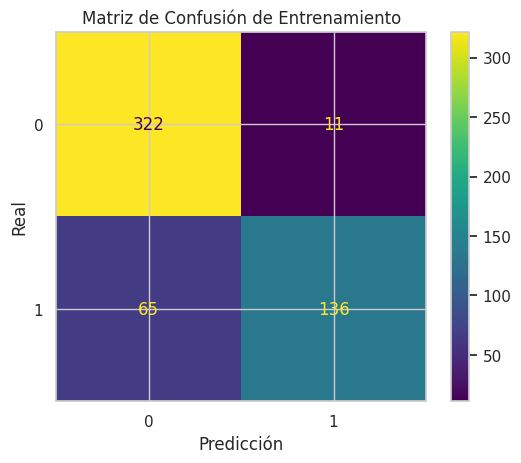

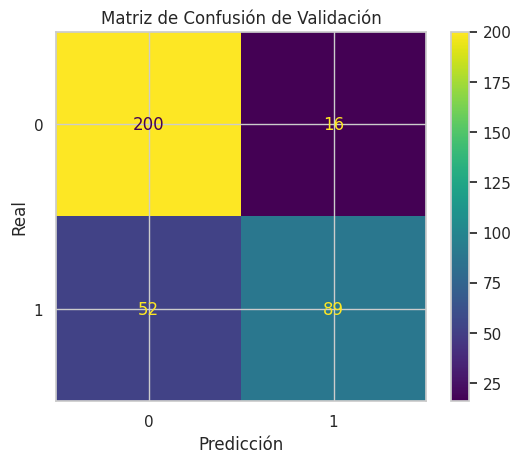

In [147]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validacion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

**Predicciones con modelo entrenado**

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [148]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

# Elegir tres índices aleatorios únicos de X_test
random_indices = random.sample(range(n_samples), min(3, n_samples))

pred_puntuales = best_classifier.predict(three_X_samples)

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Prediccion': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
resultado_df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


,Real,Prediccion
0,0,0
1,1,0
2,0,0


#### 1.3 Regresión Logística Múltiple

Para más información sobre la implementación favor de consultar el reporte final del reto en la sección Selección, Configuración y Entrenamiento del Modelo. El reporte esta ubicado en el repositorio en la carpeta llamada Modelos, junto con las carpetas de cada modelo. El nombre del archivo es: ReporteFinal_Equipo7.pdf. También se puede consultar por medio del siguiente link: https://docs.google.com/document/d/199vDBFCTWJKEMpJC6qNKBOe6Gf4dxnn06aPI6NvIPmA/edit?usp=sharing

Elaborado por Marcelo Márquez Murillo - A01720588, para la clase TC3006C.101 del equipo 7

##### 1.3.1 Descripción del modelo
La regresión logística múltiple es un modelo de aprendizaje el cual se utiliza para problemas de clasificación donde hay varios valores a considerar. En sí, este modelo es una extensión de la regresión logística binaria pero que permite más de una variable independiente (x) mientras que el resultado siga siendo una variable dependiente binaria (y).

En si la regresión logística múltiple tiene dos objetivos:
1. Entender cómo ciertos factores pueden influir en la probabilidad de que algo específico suceda. Por ejemplo, cómo afecta la edad y el sexo en la probabilidad de comprar algún producto o en el caso del reto, la probabilidad de sobrevivir un suceso como el Titanic.
2. Encontrar la forma más simple y efectiva de usar varias variables con el fin de predecir algún resultado.

##### 1.3.2 ¿Porqué se seleccionó como modelo?
Dado a la naturaleza de los datos de este reto, disponemos de un conjunto de datos los cuales detallan diversas características de los pasajeros del Titanic, como su clases social, edad y sexo, al igual de si sobrevivieron o no el desastre expresado de manera binaria (1 para sobrevivientes y 0 para no sobrevivientes). Este modelo fue seleccionado por las siguientes razones:
1. Facilidad de interpretación: A diferencia de modelos más complejos como el Random Forest o KNN, la regresión logística múltiple ofrece una interpretación más directa y comprensible de cómo cada variable influye en la probabilidad de que un pasajero sobreviva.
2. Eficiencia: Este modelo es relativamente rápido de entrenar al igual que validar, el cual es útil cuando se necesita iterar y/o ajustar el modelo varias veces.
3. La variable dependiente es binaria.

##### 1..3 Metodología utilizada para construir el modelo
1. Selección de variables: Se deben de escoger qué variables independientes serán utilizadas para entrenar al modelo. La inclusión de variables irrelevantes pueden llegar a afectar la eficiencia del modelo.
2. Usos de theta: Considerando la cantidad de variables independientes que se utilizaran, se tendrá la misma cantidad de thetas mas uno (tomando en cuenta la base o theta0) todos con valor de 1.
3. Número de iteraciones y el learning rate: A prueba y error, se cambiaban los estos valores con fin de conseguir un modelo que esté mejor entrenado y logre acertar correctamente a las predicciones.
4. Validación del Modelo: A través del empleo de herramientas analíticas como la matriz de confusión, y métricas especializadas como la exactitud, la precisión, la sensibilidad y la puntuación F1, somos capaces de evaluar de manera exhaustiva el rendimiento del modelo entrenado. Este enfoque nos permite iterar y refinar el modelo con el objetivo de optimizar los resultados obtenidos.


##### 1.3.4 Entrenamiendo del modelo

In [149]:
class LogisticRegression:
    def __init__(self, independent, dependent, num_iters, learning_rate):
        self.dependent = dependent
        self.n = len(dependent)
        # Agregar una columna de unos para que se multiple con el theta0
        self.independent = np.c_[np.ones(self.n), independent]
        self.num_iters = num_iters
        self.learning_rate = learning_rate
        # Crear lista de unos tomando en cuenta el número de variables independientes +1
        self.theta = np.ones(independent.shape[1] + 1)

    def h(self, x_n):
        # Multiplicación de matriz de variables independientes con lista de theta
        # z = theta0*1 + theta1*xi1 + theta2*xi2
        z = np.dot(x_n, self.theta)
        return 1 / (1 + np.exp(-z))

    def fit(self):
        # Iniciar un bucle que se ejecutará durante 'num_iters' iteraciones
        for i in range(self.num_iters):

            # Utilizar el método 'h' para calcular las predicciones de todas las muestras
            # Esto se realiza utilizando la matriz completa de variables independientes
            predictions = self.h(self.independent)

            # Calcular el error (o delta) entre las predicciones y los valores reales (dependientes)
            # El resultado es un vector que contiene el error para cada muestra
            delta = predictions - self.dependent

            # Calcular el gradiente del error con respecto a los parámetros theta
            # Para ello, se realiza el producto punto entre la matriz traspuesta de las variables independientes
            # y el vector de errores, y luego se divide por el número total de muestras (self.n)
            gradient = np.dot(self.independent.T, delta) / self.n

            # Actualizar los valores de los parámetros theta utilizando el gradiente y la tasa de aprendizaje
            # La actualización se realiza en dirección opuesta al gradiente para minimizar la función de costo
            self.theta -= self.learning_rate * gradient

        # Imprimir los valores finales de los parámetros theta
        print(f"Thetas finales: {self.theta}")


    def predict(self, xi):
        # Renglón de X y le agregamos un 1 para theta0
        xi = np.c_[np.ones(xi.shape[0]), xi]
        prob = self.h(xi)
        return np.round(prob)

    @staticmethod
    def evaluate(y_true, y_pred):
        vp = 0
        vn = 0
        fp = 0
        fn = 0

        # Conseguimos matriz de confusión
        n = len(y_true)
        for i in range(n):
            if y_pred[i] == 1:
                if y_true[i] == 1:
                    vp += 1
                else:
                    fp += 1
            else:
                if y_true[i] == 0:
                    vn += 1
                else:
                    fn += 1
        print(f"Model: vp - {vp}, vn - {vn}, fp - {fp}, fn - {fn}")

        # Conseguimos las métricas
        a = round((vp + vn) / (vp + vn + fp + fn), 2)
        p = round(vp / (vp + fp), 2)
        r = round(vp / (vp + fn), 2)
        f1 = round((2 * p * r) / (p + r), 2)
        print(f"Accuracy: {a}, Precision: {p}, Recall: {r}, F1 Score: {f1}")

In [150]:
# Crear modelo
model = LogisticRegression(independent=X_train, dependent=y_train, num_iters=10000, learning_rate=0.05)
# Entrenamos al modelo
model.fit()

Thetas finales: [ 2.126543   -0.77562056 -0.07800413 -2.21049298  0.26391516  0.0673139
 -0.19444621  0.36277953]


##### 1.3.5 Análisis de desempeño

**Métricas de desempeño para subconjuntos de entrenamiento y validación**

Para evaluar el desempeño del árbol de desición se prueba con los subconjuntos de entrenamiento y validación para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [151]:
predictions_val = model.predict(X_val)
predictions_train = model.predict(X_train)

# Metricas de desempeno para subconjunto de entrenamiento
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, predictions_train)

# Metricas de desempeno para subconjunto de validacion
confusion_matrix_val, accuracy_score_val, precision_score_val, recall_score_val, f1_score_val = metricas_desempeno(y_val, predictions_val)

# Create a DataFrame to display the metrics
rlm_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Validation': [accuracy_score_val, precision_score_val, recall_score_val, f1_score_val]
})

rlm_metrics_df

,Metric,Train,Validation
0,Accuracy,0.794007,0.784314
1,Precision,0.738220,0.738806
2,Recall,0.701493,0.702128
3,F1 Score,0.719388,0.720000


**Matriz de confusión**

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y validación.

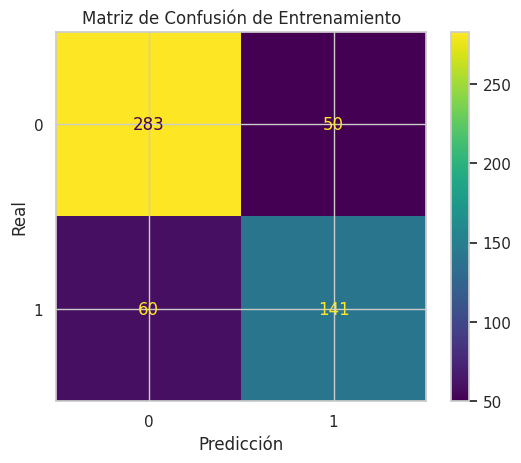

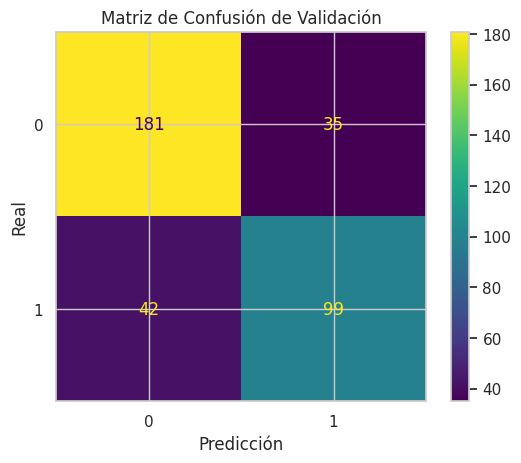

In [152]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de validación
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val)
disp.plot()
plt.title('Matriz de Confusión de Validación')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

**Predicciones con modelo entrenado**

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de validación.

In [153]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_val)

random_indices = random.sample(range(n_samples), min(3, n_samples))

# Asegurarse de que los índices seleccionados estén dentro del rango válido
random_indices = [idx for idx in random_indices if idx < n_samples]

# Obtener las muestras de X_val y y_val utilizando los índices seleccionados
# three_X_samples = [X_val.iloc[i] for i in random_indices]
# three_y_samples = [y_val.iloc[i] for i in random_indices]

# Realizar las predicciones en las muestras seleccionadas
pred_puntuales = [predict_random_forest(forest, sample) for sample in three_X_samples]

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Predicción': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
print(resultado_df)

   Real  Predicción
0     0           0
1     1           0
2     0           0


### 2. Elección del mejor modelo

In [154]:
# Agrega una columna "Model" en cada DataFrame para indicar el modelo
rfc_metrics_df['Model'] = 'Random Forest Classifier'
knn_metrics_df['Model'] = 'K-Nearest Neighbor'
rlm_metrics_df['Model'] = 'Regresión Lineal Multivariable'

# Agrega una columna "Subset" en cada DataFrame para indicar el tipo de subconjunto
rfc_metrics_df['Subset'] = 'Train'
knn_metrics_df['Subset'] = 'Train'
rlm_metrics_df['Subset'] = 'Train'

# Concatena los DataFrames en uno solo para el conjunto de entrenamiento
frames_train = [rfc_metrics_df, knn_metrics_df, rlm_metrics_df]
df_train = pd.concat(frames_train, ignore_index=True)

# Reformatea el DataFrame para tener las métricas como columnas
df_train = df_train.pivot(index=['Model', 'Subset'], columns='Metric', values='Train')

# Reinicia el índice
df_train.reset_index(inplace=True)

# Cambia el nombre de las columnas
df_train.columns.name = None

# Ahora, haz lo mismo para el conjunto de validación
# Agrega una columna "Subset" en cada DataFrame para indicar el tipo de subconjunto
rfc_metrics_df['Subset'] = 'Validation'
knn_metrics_df['Subset'] = 'Validation'
rlm_metrics_df['Subset'] = 'Validation'

# Concatena los DataFrames en uno solo para el conjunto de validación
frames_val = [rfc_metrics_df, knn_metrics_df, rlm_metrics_df]
df_val = pd.concat(frames_val, ignore_index=True)

# Reformatea el DataFrame para tener las métricas como columnas
df_val = df_val.pivot(index=['Model', 'Subset'], columns='Metric', values='Validation')

# Reinicia el índice
df_val.reset_index(inplace=True)

# Cambia el nombre de las columnas
df_val.columns.name = None

# Concatenar los DataFrames
result = pd.concat([df_train, df_val], ignore_index=True)

result

,Model,Subset,Accuracy,F1 Score,Precision,Recall
0,K-Nearest Neighbor,Train,0.857678,0.781609,0.925170,0.676617
1,Random Forest Classifier,Train,0.835206,0.768421,0.815642,0.726368
2,Regresión Lineal Multivariable,Train,0.794007,0.719388,0.738220,0.701493
3,K-Nearest Neighbor,Validation,0.809524,0.723577,0.847619,0.631206
4,Random Forest Classifier,Validation,0.806723,0.737643,0.795082,0.687943
5,Regresión Lineal Multivariable,Validation,0.784314,0.720000,0.738806,0.702128


**Observaciones:**
- En los dos subconjuntos, el modelo **K-Nearest Neighbor** tiene el Accuracy más alto tanto en Train (0.857678) como en Validation (0.809524).
- En Validation, el modelo **Regresión Lineal Multivariable** tiene el F1 Score más alto (0.720000), seguido de cerca por **K-Nearest Neighbor** (0.723577).
- En Train, **K-Nearest Neighbor** tiene la Precision más alta (0.925170), y en Validation, **K-Nearest Neighbor** también tiene la Precision más alta (0.847619).
- En Validation, **K-Nearest Neighbor** tiene el Recall más alto (0.631206), y en Train, **Random Forest Classifier** tiene el Recall más alto (0.706468).

**Random Forest** es un modelo mas preferible a KNN o Regresión Logística para abordar la problemática del conjunto de datos del Titanic en Kaggle:

Esto es debido a que el modelo de Random Forest tiene mejor capacidad de manejar relaciones no lineales:

- Random Forest: Este modelo es capaz de capturar relaciones no lineales en los datos. Dado que la supervivencia en el Titanic puede depender de múltiples factores de manera no lineal (como la edad, la clase social y el sexo), Random Forest puede ser más adecuado para capturar estas relaciones complejas.

- KNN: KNN asume que los datos similares están cerca unos de otros en el espacio de características, lo que puede no ser el caso en situaciones donde las relaciones son no lineales. Además, la elección de un valor adecuado para "k" en KNN puede ser subjetiva y requerir ajuste.

- Regresión Logística: Aunque es un modelo útil, la Regresión Logística es intrínsecamente lineal y puede no ser tan efectiva para modelar relaciones complejas en los datos del Titanic.

Manejo de variables categóricas:

- Random Forest: Puede manejar variables categóricas fácilmente mediante la técnica de "codificación one-hot" o mediante una estrategia de codificación más avanzada como "target encoding". Esto es beneficioso, ya que el conjunto de datos del Titanic contiene variables categóricas importantes como "Clase" y "Sexo".

- KNN: KNN puede tener dificultades para manejar eficazmente variables categóricas sin un preprocesamiento adecuado, como la codificación one-hot.

- Regresión Logística: La Regresión Logística puede manejar variables categóricas mediante la creación de variables ficticias, pero esto puede aumentar la dimensionalidad del conjunto de datos.

Manejo de overfitting:

- Random Forest: Tiene la capacidad de manejar el overfitting mediante la selección aleatoria de subconjuntos de características en cada árbol y la agregación de múltiples árboles.

- KNN: KNN tiende a sufrir más de overfitting, especialmente cuando se usa un valor de "k" pequeño.

Regresión Logística: Puede ser propenso al overfitting si se incluyen demasiadas variables independientes irrelevantes.

Rendimiento con grandes conjuntos de datos:

- Random Forest: A menudo, es eficiente en términos de tiempo de entrenamiento incluso con grandes conjuntos de datos debido a la paralelización y la naturaleza escalable de los árboles de decisión.

- KNN: Puede volverse computacionalmente costoso cuando se trabaja con grandes conjuntos de datos, ya que debe calcular las distancias entre todas las muestras en el conjunto de entrenamiento.

- Regresión Logística: Tiende a ser eficiente en términos de tiempo de entrenamiento, pero puede no ser tan adecuada para grandes conjuntos de datos en comparación con Random Forest.

En resumen,para la problemática del conjunto de datos del Titanic en Kaggle se rquiere utilizar un modelo que sea capaz de capturar relaciones no lineales, manejar eficazmente variables categóricas y controlar el overfitting, Random Forest es nuestra elección sólida en comparación con KNN o Regresión Logística.

# **Evidencia 3: Evaluación y Refinamiento de modelo**

En este proyecto, se propone crear un modelo de clasificación utilizando el algoritmo Random Forest. Para llevar a cabo este proceso, optamos por utilizar Python como lenguaje de programación y el framework de sklearn, ya que es conocido por su facilidad de uso y una amplia gama de bibliotecas disponibles para la manipulación y análisis de datos.

Se utilizara el dataset de **Titanic** donde, **se predice si una persona sobrevivió o no al desastre del Titanic**. Para conocer más sobre este proyecto se puede consultar el siguiente link: https://www.kaggle.com/competitions/titanic

El proceso estara documentado con comentarios en el código, y mostrara paso a paso el desarrollo del modelo con el uso del framework.

Los archivos que estaremos utilizando del ETL son **train_etl y test_etl**.

Ambos archivos se encuentran aqui:

https://drive.google.com/file/d/1T_ZRV0zAYqC3d1am8xCXJ6CqDRyptBw0/view?usp=sharing

https://drive.google.com/file/d/1gJDScqXANL15oZilDhXhkL_fxIa-Jrjh/view?usp=sharing



## Configuración Inicial del Modelo

1. criterion = "gini"
2. n_estimators = 100
3. max_depth = 5

**Parametros**

criterion: Opción que permite especificar la medida de calidad que se utiliza para tomar decisiones sobre la división de nodos durante la construcción de los árboles en el bosque aleatorio

min_impurity_decrease: Este hiper parámetro controla la cantidad mínima de reducción requerida en la impureza (criterio de división) para que se produzca una división en un nodo del árbol. Se configura min_impurity_decrease en 0.02, lo que significa que se requerirá una reducción relativamente grande en la impureza para dividir un nodo. Este valor ayuda a limitar la profundidad del árbol y prevenir divisiones que no proporcionen una mejora significativa en la calidad de las divisiones.

max_depth: Limitamos la profundidad máxima de cada árbol a 5. Esto significa que ningún árbol en el bosque tendrá más de 5 niveles de profundidad. Limitar la profundidad de los árboles puede ayudar a controlar la complejidad del modelo y evitar un sobreajuste excesivo a los datos de entrenamiento.

min_samples_split: Configuramos min_samples_split en 10, lo que significa que se requerirán al menos 10 muestras en un nodo para que se realice una división. Esto puede ayudar a prevenir divisiones en nodos con un número muy bajo de muestras, lo que nuevamente contribuye a evitar un sobreajuste.

n_estimators: Configuramos n_estimators en 100, lo que indica que estamos construyendo un bosque de 100 árboles de decisión. Tener un número moderado de árboles en el bosque puede ser eficiente en términos computacionales y suele ser suficiente para obtener un buen rendimiento.

## Importar módulos

In [155]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler # Funcion para escalar datos
import graphviz
from sklearn.tree import export_graphviz

## Cargar datos

In [156]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/train_etl.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Solucion/test_etl.csv')

#Descripcion de datos
cantidad_registros = len(train_df)
numero_caracteristicas = len(train_df.columns) - 1
valores_salida = train_df["Survived"].unique()
print("Descripcion de Diabetes Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")
train_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descripcion de Diabetes Dataset
Cantidad de registros: 891
Número de características: 7
Valores de salida: [0 1]


,Pclass,Age,Sex,IsAlone,Fare,Embarked,Title,Survived
0,3,2,1,0,1,2,1,0
1,1,4,0,0,5,1,2,1
2,3,2,0,1,2,2,3,1
3,1,4,0,0,5,2,2,1
4,3,4,1,1,2,2,1,0
...,...,...,...,...,...,...,...,...
886,2,3,1,1,3,2,5,0
887,1,1,0,1,4,2,3,1
888,3,2,0,0,4,2,3,0
889,1,2,1,1,4,1,1,1


## Separación de datos en subconjuntos

Para entrenar al modelo se dividen los datos en los subconjuntos de entrenamiento, vaidación y prueba en una proporción de sesenta, veinte y veinte respectivamente. Para realizar este división se utiliza la función **train_test_split**, la cual selecciona las muestras para cada subconjunto aleatoriamente.

Además, con el propósito de evitar un sesgo en el modelo se **escalan** los datos de los subconjuntos de entrenamiento, validación y prueba. Para esto se utiliza el módulo de **preprocesamiento de sklearn**.

In [157]:
# Separar la columna 'Survived' para el conjunto de entrenamiento
n = len(train_df.columns) - 1
X = train_df.iloc[:, 0:n]
y = train_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (60%) y validación (40%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)


## Entrenamiento del modelo

### Modelo hipótesis

Para analizar más a fondo el modelo hipótesis se grafica el error de las predicciones realizadas por el modelo contra el tamaño del subconjunto de entrenamiento.

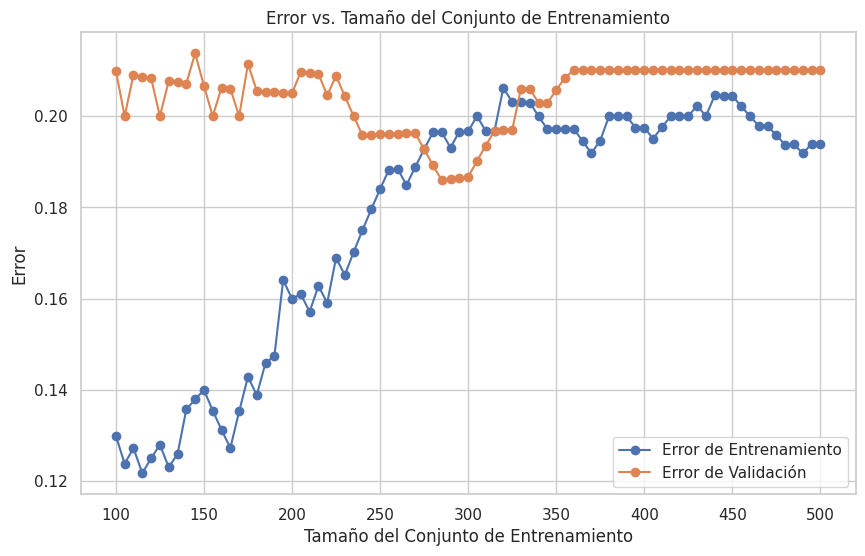

In [158]:
def error_modelo(modelo):
  # Inicializa listas de errores para subconjuntos
  train_errors = []
  val_errors = []

  # Tamanos de subconjunto
  training_sizes = range(100, 501, 5)

  for size in training_sizes:
      # Selecciona un subconjunto de entrenamiento del tamano actual
      X_train_subset = X_train[:size]
      y_train_subset = y_train[:size]
      X_val_subset = X_val[:size]
      y_val_subset = y_val[:size]

      # Realiza predicciones en los conjuntos de entrenamiento y validacion
      y_train_pred = modelo.predict(X_train_subset)
      y_val_pred = modelo.predict(X_val_subset)

      # Calcula los errores de entrenamiento y validacion
      train_error = 1 - accuracy_score(y_train_subset, y_train_pred)
      val_error = 1 - accuracy_score(y_val_subset, y_val_pred)

      # Agrega los errores a las listas
      train_errors.append(train_error)
      val_errors.append(val_error)

  plt.figure(figsize=(10, 6))
  plt.plot(training_sizes, train_errors, label='Error de Entrenamiento', marker='o')
  plt.plot(training_sizes, val_errors, label='Error de Validación', marker='o')
  plt.title('Error vs. Tamaño del Conjunto de Entrenamiento')
  plt.xlabel('Tamaño del Conjunto de Entrenamiento')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

# Modelo hipotesis
tree = RandomForestClassifier(criterion="gini", n_estimators=100, max_depth=3)
tree.fit(X_train, y_train)
error_modelo(tree)

**Observaciones:**
- Los errores de ambos subconjuntos estan muy separados, esto es señal de que hay un sobreajuste del modelo (overffiting). Por lo tanto, se tiene una **varianza media** y un **sesgo bajo**.
- El error del modelo incrementa a medida que el subconjunto de entrenamiento crece, indicador de que el modelo no es el ideal.

Por lo tanto, el modelo hipótesis no es el indicado porque padece de overfitting. Hay muy poco error en subset de entrenamiento y no generaliza bien.

### Ajuste de parámetro max_depth

Considerando estas observaciones se toma la decisión de ajustar el parámetro **max_depth** para reducir el overfitting del modelo anterior. A continuación, se busca el la valor de **max_depth** ideal para reducir el error de validación y entrenamiento.

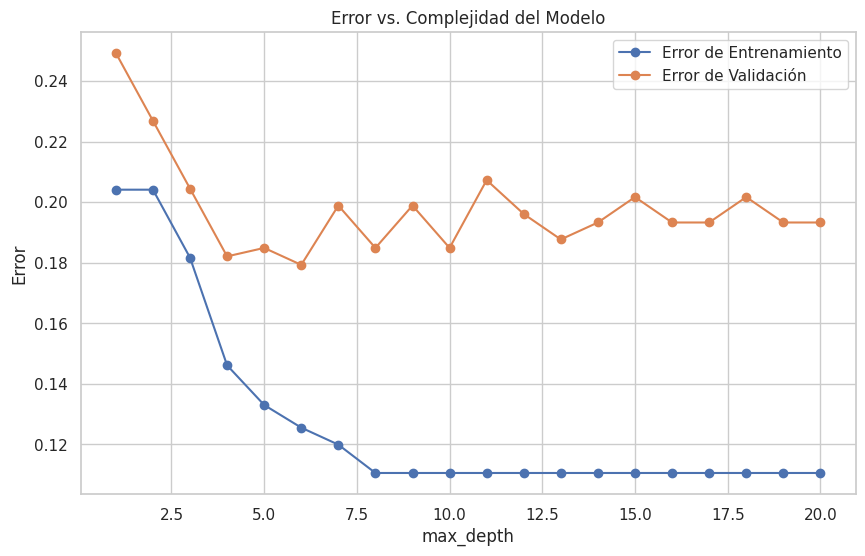

In [159]:
# Define una lista de valores de max_depth que se desea probar
max_depth_values = range(1, 21, 1)

# Inicializa listas para almacenar los errores de entrenamiento y validacion
train_errors = []
val_errors = []

# Itera a traves de los valores de max_depth
for max_depth in max_depth_values :
    # Crea y entrena un modelo de arbol con la max_depth actual
    tree = RandomForestClassifier(criterion="gini", n_estimators=100, max_depth=max_depth)
    tree.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validacion
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Calcula el error de entrenamiento y validacion
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la grafica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(max_depth_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Observación:** El mejor valor de max_depth parece ser de cinco, hay una reducción significativa en los subconjuntos de validación y entrenamiento.

Ajustando el parámetro max_depth a cinco, se revisa si hay una reducción de overffiting del modelo.

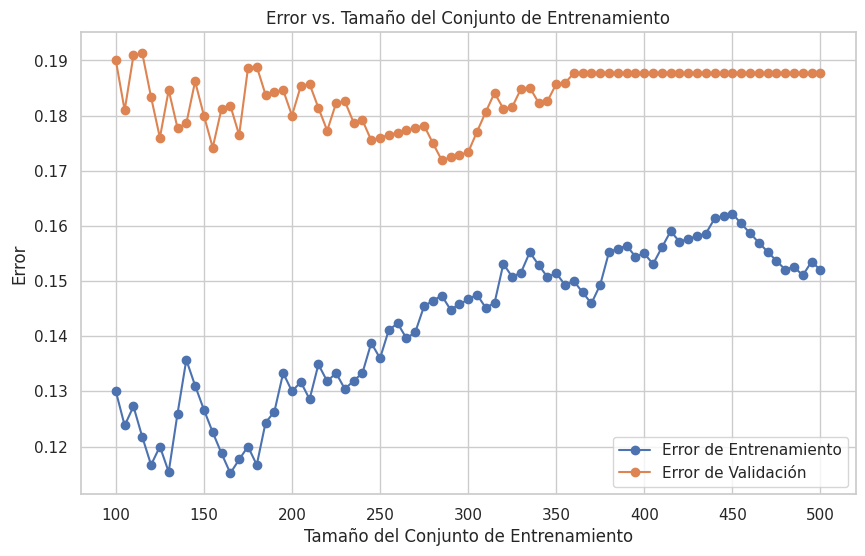

In [160]:
# Modelo con ajuste de max_depth
tree = RandomForestClassifier(criterion="gini", n_estimators=100, max_depth=4)
tree.fit(X_train, y_train)
error_modelo(tree)

**Observaciones:**
- Hay una reducción de la diferencia de error entre ambos subconjuntos. Por lo tanto, el ajuste del modelo disminuyó en cuanto a sobreajuste (overffiting). Ahora hay una **varianza** más **baja** y un **sesgo bajo**.
- El error del subconjunto de entrenamiento es muy volátil.

### Ajuste de parámetro n_estimators

Considerando estas observaciones se toma la decisión de ajustar el parámetro **n_estimators** para reducir el overfitting del modelo anterior. A continuación, se busca el la valor de **n_estimators** cantidad de arboles ideal para reducir el error de validación y entrenamiento.

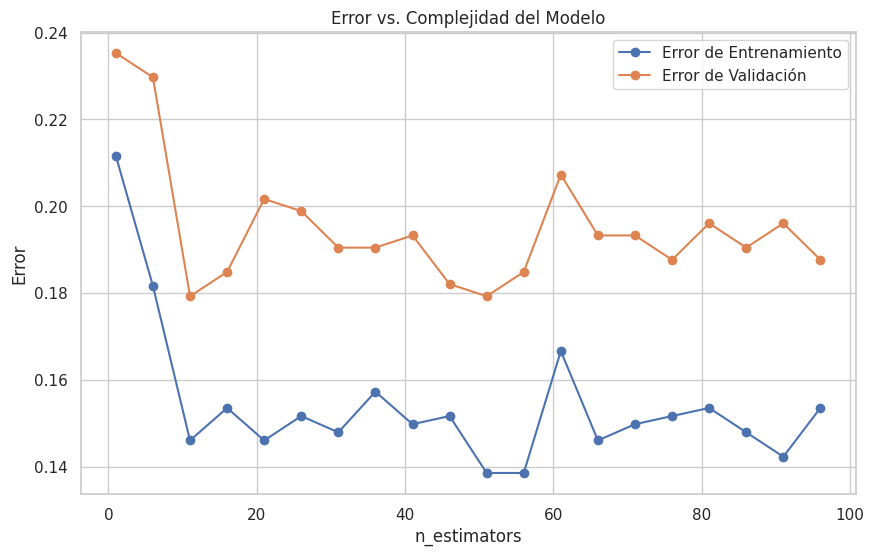

In [161]:
# Define una lista de valores de n_estimators que se desea probar
n_estimators_values = range(1, 100, 5)

# Inicializa listas para almacenar los errores de entrenamiento y validación
train_errors = []
val_errors = []

# Itera a través de los valores de n_estimators
for n_estimators in n_estimators_values:
    # Crea y entrena un modelo de Random Forest con el n_estimators actual
    modeloRandomForest = RandomForestClassifier(criterion="gini", n_estimators=n_estimators, max_depth=4)
    modeloRandomForest.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validación
    y_train_pred = modeloRandomForest.predict(X_train)
    y_val_pred = modeloRandomForest.predict(X_val)

    # Calcula el error de entrenamiento y validación
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la gráfica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(n_estimators_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

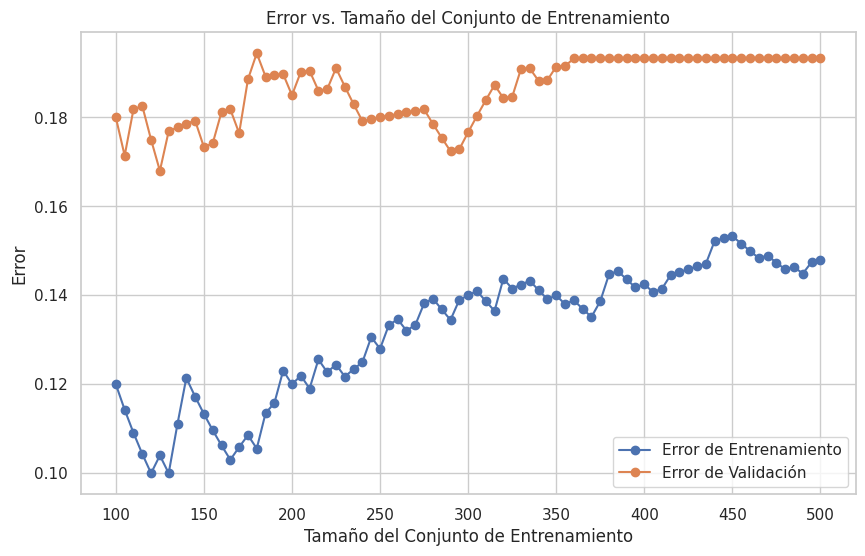

In [162]:
# Modelo con ajuste de max_depth
tree = RandomForestClassifier(criterion="gini", n_estimators=21, max_depth=5)
tree.fit(X_train, y_train)
error_modelo(tree)

### Ajuste de parámetro min_samples_split

Considerando estas observaciones se toma la decisión de ajustar el parámetro **min_samples_split** para reducir el overfitting del modelo anterior. A continuación, se busca el la valor de **min_samples_split** cantidad de nodos ideal para reducir el error de validación y entrenamiento.

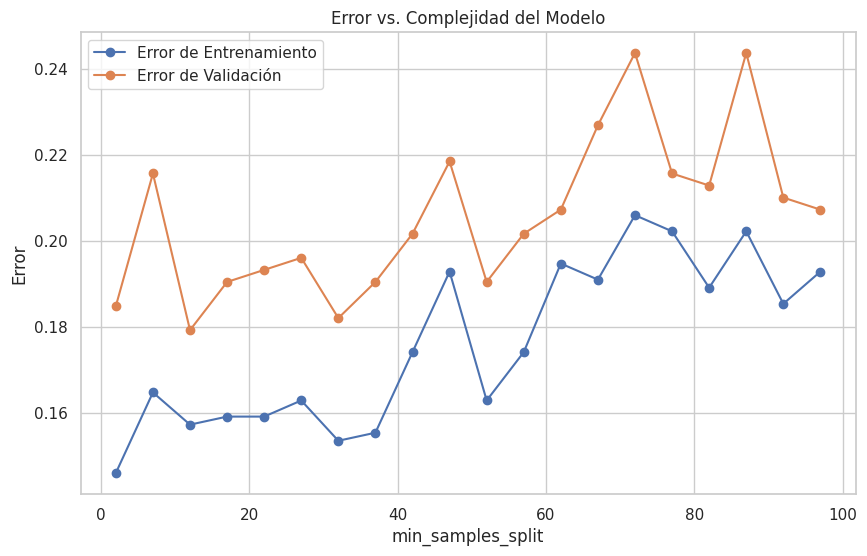

In [163]:
# Define una lista de valores de min_samples_split que se desea probar
min_samples_split_values = range(2, 100, 5)

# Inicializa listas para almacenar los errores de entrenamiento y validación
train_errors = []
val_errors = []

# Itera a través de los valores de min_samples_split
for min_samples_split in min_samples_split_values:
    # Crea y entrena un modelo de Random Forest con el min_samples_split actual
    modeloRandomForest = RandomForestClassifier(criterion="gini", n_estimators=21,  max_depth=4, min_samples_split=min_samples_split)
    modeloRandomForest.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validación
    y_train_pred = modeloRandomForest.predict(X_train)
    y_val_pred = modeloRandomForest.predict(X_val)

    # Calcula el error de entrenamiento y validación
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la gráfica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(min_samples_split_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


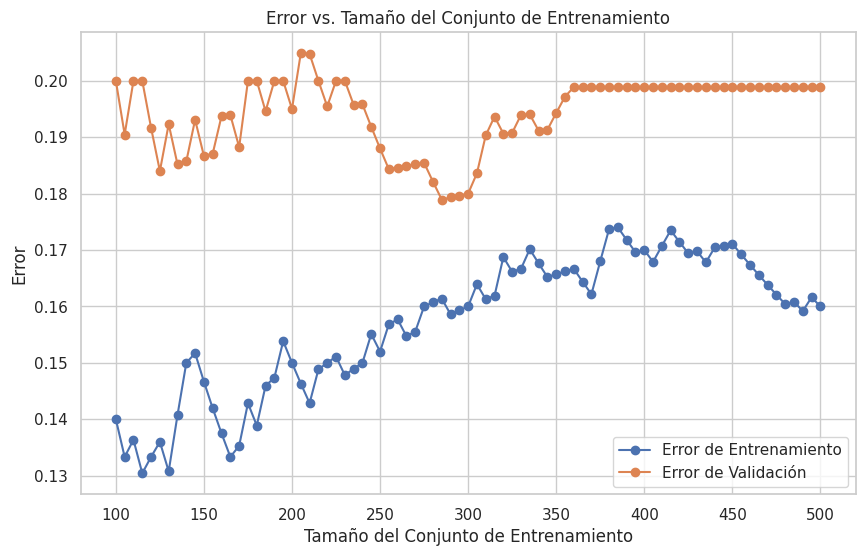

In [164]:
# Modelo con ajuste de max_depth
tree = RandomForestClassifier(criterion="gini", n_estimators=21, max_depth=5, min_samples_split=22)
tree.fit(X_train, y_train)
error_modelo(tree)

### Ajuste de parámetro min_impurity_decrease

Considerando estas observaciones se toma la decisión de ajustar el parámetro **min_impurity_decrease** para reducir el overfitting del modelo anterior. A continuación, se busca el la valor de **min_impurity_decrease** ideal para reducir el error de validación y entrenamiento.

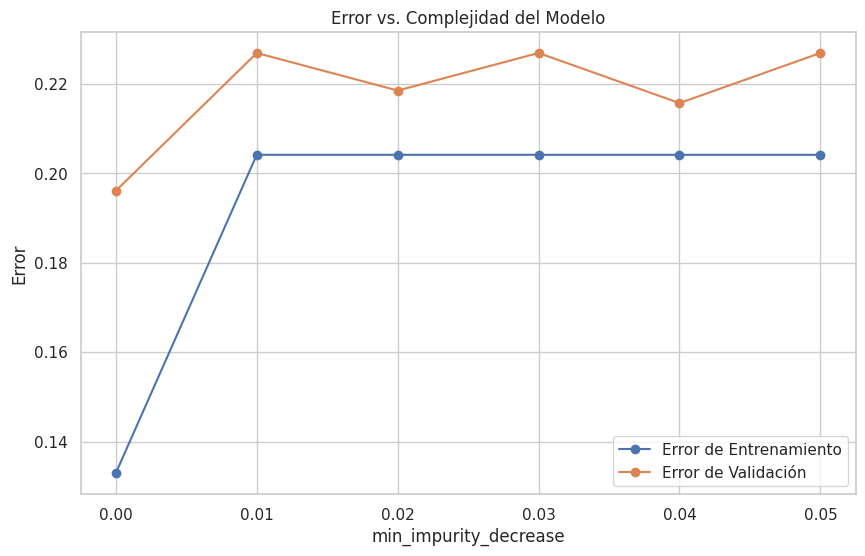

In [165]:
# Define una lista de valores de min_impurity_decrease que se desea probar
min_impurity_decrease_values = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

# Inicializa listas para almacenar los errores de entrenamiento y validación
train_errors = []
val_errors = []

# Itera a través de los valores de min_impurity_decrease
for min_impurity_decrease in min_impurity_decrease_values:
    # Crea y entrena un modelo de Random Forest con el min_impurity_decrease actual
    modeloRandomForest = RandomForestClassifier(criterion="gini", n_estimators=50, max_depth=15, min_samples_split=10, min_impurity_decrease=min_impurity_decrease)
    modeloRandomForest.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validación
    y_train_pred = modeloRandomForest.predict(X_train)
    y_val_pred = modeloRandomForest.predict(X_val)

    # Calcula el error de entrenamiento y validación
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la gráfica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(min_impurity_decrease_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(min_impurity_decrease_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('min_impurity_decrease')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


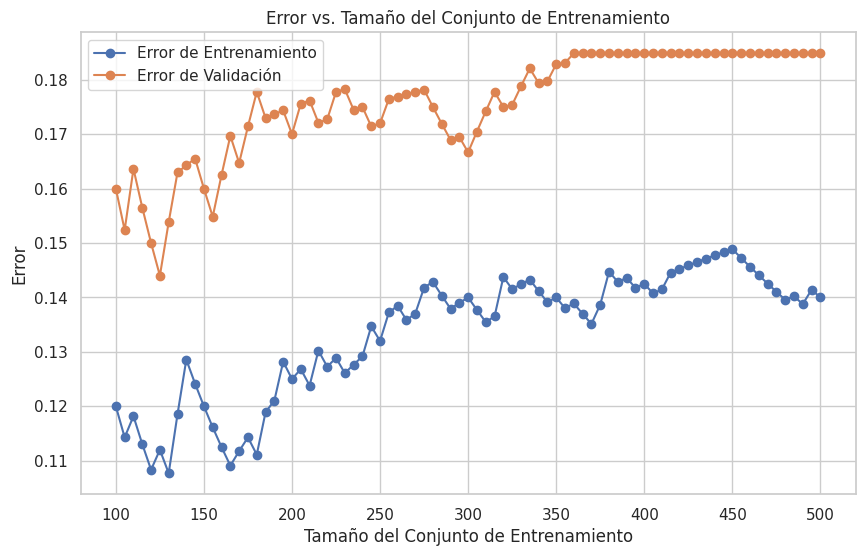

In [166]:
# Crear el modelo Random Forest con los mejores hiperparametros con de acuerdo a las graficas
modeloRandomForestConf = RandomForestClassifier(criterion='entropy', n_estimators = 60, max_depth = 20, min_samples_split = 10, random_state=42)
modeloRandomForestConf.fit(X_train, y_train)
error_modelo(modeloRandomForestConf)

## Análisis de desempeño

### Curva aprendizaje

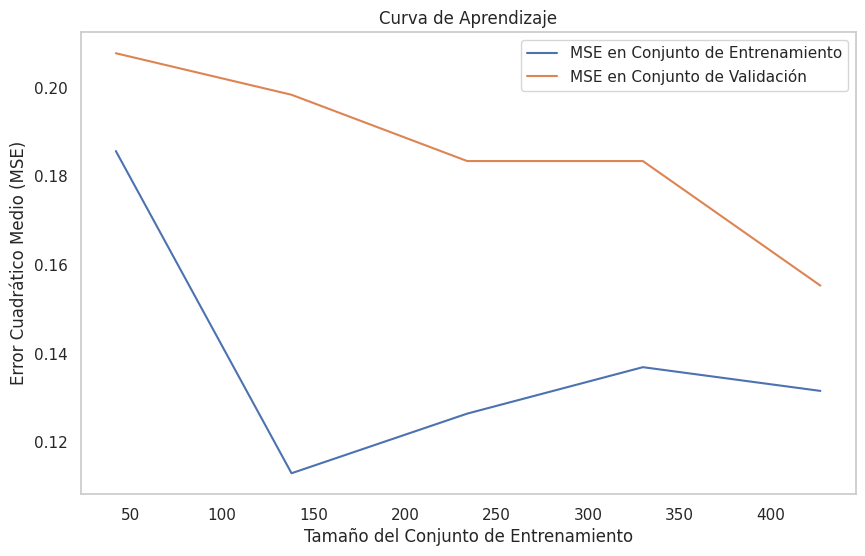

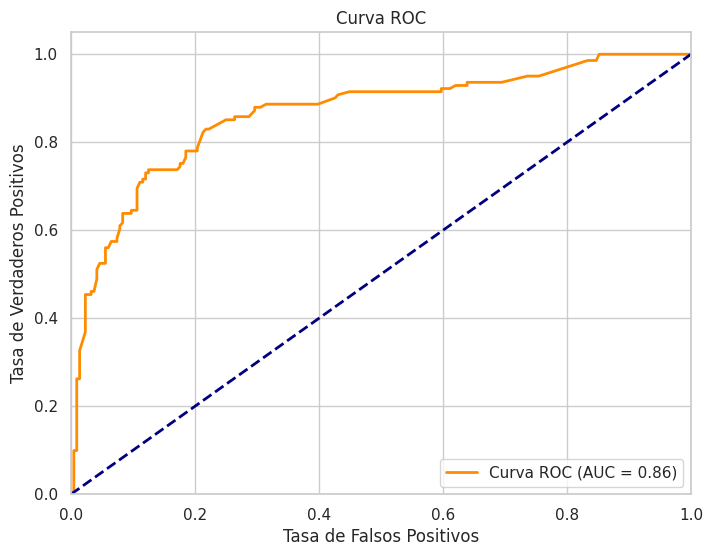

In [167]:
# Visualizar la curva de aprendizaje (learning curve)
# Calcular el error cuadrático medio (MSE) en el conjunto de entrenamiento y validación
train_sizes, train_errors, val_errors = learning_curve(
    modeloRandomForestConf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir el error a positivo y tomar la media
train_errors = -np.mean(train_errors, axis=1)
val_errors = -np.mean(val_errors, axis=1)

# Visualizar la curva de aprendizaje del MSE
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='MSE en Conjunto de Entrenamiento')
plt.plot(train_sizes, val_errors, label='MSE en Conjunto de Validación')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()

# Calcular y visualizar las curvas ROC en el conjunto de validación
y_val_prob = modeloRandomForestConf.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [168]:
# Predecir los valores en el conjunto de prueba
modeloRandomForestConf = RandomForestClassifier(criterion="gini", n_estimators=66, max_depth=15, min_samples_split=10)
modeloRandomForestConf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=66)

### Resultados del subconjunto de validacion

Métricas en el conjunto de prueba:
Accuracy score: 0.8370786516853933
Precision score: 0.8275862068965517
Recall score: 0.7164179104477612
F1 score: 0.768


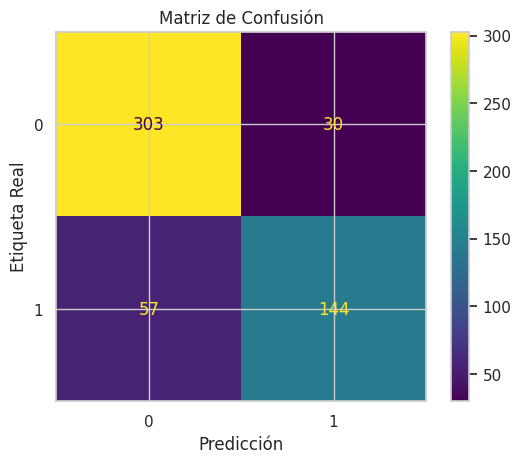

'decision_tree.pdf'

In [169]:
# Predecir los valores en el conjunto de prueba
modeloRandomForestConf = RandomForestClassifier(criterion="gini", n_estimators=21, max_depth=4, min_samples_split=22)
modeloRandomForestConf.fit(X_train, y_train)
y_pred = modeloRandomForestConf.predict(X_train)

# Calcular las métricas
print("Métricas en el conjunto de prueba:")
print("Accuracy score:", accuracy_score(y_train, y_pred))
print("Precision score:", precision_score(y_train, y_pred))
print("Recall score:", recall_score(y_train, y_pred))
print("F1 score:", f1_score(y_train, y_pred))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión como una imagen
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

# Visualizar un árbol del random forest
estimator = modeloRandomForestConf.estimators_[0]  # Seleccionar el primer árbol
myTreeData = export_graphviz(estimator, out_file=None,
                            feature_names= X_train.columns,
                            class_names=['Not Survived', 'Survived'],
                            filled=True, rounded=True, special_characters=True)

graphData = graphviz.Source(myTreeData)
graphData.view(filename='decision_tree')

###Guardamos las predicciones con los datos de prueba

In [172]:
# Realizar predicciones en el conjunto de prueba
y_pred_test = modeloRandomForestConf.predict(X_val)

# Crear un DataFrame con las predicciones
results_df = pd.DataFrame({'Predicciones del Conjunto Prueba': y_pred_test})

# Visualizar el DataFrame con las predicciones
print(results_df)

     Predicciones del Conjunto Prueba
0                                   1
1                                   0
2                                   0
3                                   1
4                                   1
..                                ...
352                                 0
353                                 0
354                                 1
355                                 0
356                                 0

[357 rows x 1 columns]


### Predicciones puntuales

In [173]:
# Crear un DataFrame con datos de ejemplo
nuevos_datos_manual = pd.DataFrame({
    'Pclass': [1],
    'Sex': [0],
    'Age': [36],
    'IsAlone': [1],
    'Fare': [3],
    'Title': [1],
    'Embarked': [1]
})

# Asegurarse de que las columnas estén en el mismo orden que en el conjunto de entrenamiento
columnas_orden = X.columns  # Obtener las columnas en el mismo orden
nuevos_datos_manual = nuevos_datos_manual[columnas_orden]

# Utilizar el modelo ya entrenado para predecir los resultados para los nuevos datos ingresados manualmente
resultados_predichos_manual = modeloRandomForestConf.predict(nuevos_datos_manual)

# Imprimir los resultados de la prediccion
for resultado in resultados_predichos_manual:
    if resultado == 0:
        print("No sobrevivió")
    else:
        print("Sobrevivió")

Sobrevivió


In [174]:
# Crear un DataFrame con datos de ejemplo
nuevos_datos_manual = pd.DataFrame({
    'Pclass': [2],
    'Sex': [1],
    'Age': [22],
    'IsAlone': [0],
    'Fare': [3],
    'Title': [1],
    'Embarked': [1]
})

# Asegurarse de que las columnas estén en el mismo orden que en el conjunto de entrenamiento
columnas_orden = X.columns  # Obtener las columnas en el mismo orden
nuevos_datos_manual = nuevos_datos_manual[columnas_orden]

# Utilizar el modelo ya entrenado para predecir los resultados para los nuevos datos ingresados manualmente
resultados_predichos_manual = modeloRandomForestConf.predict(nuevos_datos_manual)

# Imprimir los resultados de la prediccion
for resultado in resultados_predichos_manual:
    if resultado == 0:
        print("No sobrevivió")
    else:
        print("Sobrevivió")

No sobrevivió


In [175]:
# Crear un DataFrame con datos de ejemplo
nuevos_datos_manual = pd.DataFrame({
    'Pclass': [2],
    'Sex': [1],
    'Age': [22],
    'IsAlone': [0],
    'Fare': [3],
    'Title': [2],
    'Embarked': [0]
})

# Asegurarse de que las columnas estén en el mismo orden que en el conjunto de entrenamiento
columnas_orden = X.columns  # Obtener las columnas en el mismo orden
nuevos_datos_manual = nuevos_datos_manual[columnas_orden]

# Utilizar el modelo ya entrenado para predecir los resultados para los nuevos datos ingresados manualmente
resultados_predichos_manual = modeloRandomForestConf.predict(nuevos_datos_manual)

# Imprimir los resultados de la prediccion
for resultado in resultados_predichos_manual:
    if resultado == 0:
        print("No sobrevivió")
    else:
        print("Sobrevivió")

No sobrevivió


# **Referencias bibliográficas**

1. Sebastian Raschka. (2015). Python Machine Learning. Packt Publishing.
2. Oracles. “¿Qué Es ETL?” Oracle.com, 2021, www.oracle.com/mx/integration/what-is-etl/#:~:text=Extracci%C3%B3n%2C%20transformaci%C3%B3n%20y%20carga%20(Extract. Accessed 22 Aug. 2023.
3. IBM. “¿Qué Es El Algoritmo de K Vecinos Más Cercanos? | IBM.” Www.ibm.com, www.ibm.com/mx-es/topics/knn.